In [2]:
import pandas as pd
import os
import numpy as np
# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, accuracy_score  # Metricas
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, cohen_kappa_score, make_scorer

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Optimizacion de hiperparametros
import optuna


import warnings

warnings.filterwarnings("ignore")

In [3]:
bbdd = "sqlite:///op-class2.sqlite3"

In [30]:
df = pd.read_excel('df_op.xlsx')
df.head(2)

,Tipo comp.,NÂ° Comp.,index,NÂ° cuenta,Desc. Cuenta,NÂ° TesorerÃ­a,Desc. TesorerÃ­a,NÂ° Entidad,Desc. Entidad,Tipo Pres.,...,Monto,Tipo cta,Cod. Bco.,Cta. Cte,NÂ° cta. Safyc,CuentaSafyc,Cuit Pago,Beneficiario Pago,Class,dias_pago
0,AF,163,11643,360000003873122,SGP-RENTAS GRALES-PAGADORA ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,...,1.618424e+08,R,7,1,387312,71387312,30710502354,FDO FID COM CEVIL REDONDO,ANR,34
1,AF,164,75911,71111333,SGP - CTA PAGADORA- CHEQUES DIFERIDOS ...,1,TESORERIA GENERAL DE LA PROVINCIA,50,SAF OBLIGACIONES A CARGO DEL TESORO,E,...,1.444338e+05,P,7,1,111333,71111333,30710500432,FDO FID COM LOS RALOS,PTE,224


In [31]:
# onehot encoding
categ = ['Tipo comp.','Tipo Reg.','Clase Reg.','Tipo cta']
for col in categ:
    df = df.join(pd.get_dummies(df[[col]]))
    df.drop(col, axis=1, inplace=True)



In [32]:
df.iloc[0]

NÂ° Comp.                                                       163
index                                                         11643
NÂ° cuenta                                          360000003873122
Desc. Cuenta      SGP-RENTAS GRALES-PAGADORA                    ...
NÂ° TesorerÃ­a                                                    1
                                        ...                        
Clase Reg._DPU                                                False
Clase Reg._OGA                                                False
Clase Reg._REM                                                False
Tipo cta_P                                                    False
Tipo cta_R                                                     True
Name: 0, Length: 65, dtype: object

In [33]:
df.columns

Index(['NÂ° Comp.', 'index', 'NÂ° cuenta', 'Desc. Cuenta', 'NÂ° TesorerÃ­a',
       'Desc. TesorerÃ­a', 'NÂ° Entidad', 'Desc. Entidad', 'Tipo Pres.',
       'Concepto', 'NÂ° Orig.', 'NÂ° Pago', 'F. Pago', 'Impreso', 'F. Impreso',
       'Confirmado', 'F. Confirmado', 'Entregado', 'F. Entregado',
       'Conciliado', 'F. Conciliado', 'F. ME', 'Anulado', 'F. Anulado',
       'Revertido', 'F. Revertido', 'Expte', 'T. Cheque', 'Cod.', 'Fte. Fin.',
       'Cuit', 'Beneficiario', 'Cuit alt.', 'Benef. alt.', 'Descripcion',
       'Tipo Pago', 'Id. Pe. Ch.', 'CBU dest.', 'Monto', 'Cod. Bco.',
       'Cta. Cte', 'NÂ° cta. Safyc', 'CuentaSafyc', 'Cuit Pago',
       'Beneficiario Pago', 'Class', 'dias_pago', 'Tipo comp._AF',
       'Tipo comp._FF', 'Tipo comp._GA', 'Tipo comp._GC', 'Tipo comp._GE',
       'Tipo Reg._AMP', 'Tipo Reg._ANT', 'Tipo Reg._APE', 'Tipo Reg._CYO',
       'Tipo Reg._ORD', 'Tipo Reg._PAG', 'Tipo Reg._RPO', 'Clase Reg._   ',
       'Clase Reg._DPU', 'Clase Reg._OGA', 'Clase 

In [35]:
np.setdiff1d(df.columns,['NÂ° cuenta', 'NÂ° Entidad', 'Cod.', 'Fte. Fin.', 'Cuit', 'Cod. Bco.','index'])

array(['Anulado', 'Benef. alt.', 'Beneficiario', 'Beneficiario Pago',
       'CBU dest.', 'Clase Reg._   ', 'Clase Reg._DPU', 'Clase Reg._OGA',
       'Clase Reg._REM', 'Class', 'Concepto', 'Conciliado', 'Confirmado',
       'Cta. Cte', 'CuentaSafyc', 'Cuit Pago', 'Cuit alt.',
       'Desc. Cuenta', 'Desc. Entidad', 'Desc. TesorerÃ\xada',
       'Descripcion', 'Entregado', 'Expte', 'F. Anulado', 'F. Conciliado',
       'F. Confirmado', 'F. Entregado', 'F. Impreso', 'F. ME', 'F. Pago',
       'F. Revertido', 'Id. Pe. Ch.', 'Impreso', 'Monto', 'NÂ° Comp.',
       'NÂ° Orig.', 'NÂ° Pago', 'NÂ° TesorerÃ\xada', 'NÂ° cta. Safyc',
       'Revertido', 'T. Cheque', 'Tipo Pago', 'Tipo Pres.',
       'Tipo Reg._AMP', 'Tipo Reg._ANT', 'Tipo Reg._APE', 'Tipo Reg._CYO',
       'Tipo Reg._ORD', 'Tipo Reg._PAG', 'Tipo Reg._RPO', 'Tipo comp._AF',
       'Tipo comp._FF', 'Tipo comp._GA', 'Tipo comp._GC', 'Tipo comp._GE',
       'Tipo cta_P', 'Tipo cta_R', 'dias_pago'], dtype=object)

In [38]:
Class = list(df.Class.unique())
clases = {val:Class.index(val) for val in Class}
def get_class(val):
    return clases[val]

df['target'] = df['Class'].apply(get_class)

In [42]:
features = []
for x in enumerate(df.dtypes):
    if x[1] in ["float64","int64","bool"]:
        features.append(df.columns[x[0]])

remove = [ 'Cuit Pago','dias_pago','target','index', 'Cta. Cte','NÂ° cta. Safyc','CuentaSafyc','NÂ° Comp.', 
          'NÂ° TesorerÃ\xada', 'NÂ° Pago','F. Anulado','F. Revertido', 'Cuit alt.','Id. Pe. Ch.','Monto', 'NÂ° Orig.',]

for col in remove:
    try:
        features.remove(col)
    except: pass
features

['NÂ° cuenta',
 'NÂ° Entidad',
 'Cod.',
 'Fte. Fin.',
 'Cuit',
 'Cod. Bco.',
 'Tipo comp._AF',
 'Tipo comp._FF',
 'Tipo comp._GA',
 'Tipo comp._GC',
 'Tipo comp._GE',
 'Tipo Reg._AMP',
 'Tipo Reg._ANT',
 'Tipo Reg._APE',
 'Tipo Reg._CYO',
 'Tipo Reg._ORD',
 'Tipo Reg._PAG',
 'Tipo Reg._RPO',
 'Clase Reg._   ',
 'Clase Reg._DPU',
 'Clase Reg._OGA',
 'Clase Reg._REM',
 'Tipo cta_P',
 'Tipo cta_R']

In [43]:
SEED = 12345
TEST_SIZE = 0.2

X = df[features]
for col in X.columns:
    if X[col].dtype == 'object':
       X[col] = pd.to_numeric(X[col], errors='coerce')
y = df.target

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [44]:
X.isna().sum()

NÂ° cuenta        0
NÂ° Entidad       0
Cod.              0
Fte. Fin.         0
Cuit              0
Cod. Bco.         0
Tipo comp._AF     0
Tipo comp._FF     0
Tipo comp._GA     0
Tipo comp._GC     0
Tipo comp._GE     0
Tipo Reg._AMP     0
Tipo Reg._ANT     0
Tipo Reg._APE     0
Tipo Reg._CYO     0
Tipo Reg._ORD     0
Tipo Reg._PAG     0
Tipo Reg._RPO     0
Clase Reg._       0
Clase Reg._DPU    0
Clase Reg._OGA    0
Clase Reg._REM    0
Tipo cta_P        0
Tipo cta_R        0
dtype: int64

## multi_logloss

In [10]:
# Define la función objetivo para Optuna
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Número de clases
        'metric': 'multi_logloss',
        #'metric': 'average_precision',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'verbose': -1,
    }
    
    # Crear el dataset de LightGBM
    dtrain = lgb.Dataset(X_train, label=y_train)
    
    # Realizar el entrenamiento y obtener los resultados de la validación cruzada
    cv_results = lgb.cv(param, dtrain, nfold=3, stratified=True)
    
    # Usamos la métrica de pérdida de entropía cruzada mínima como objetivo para optimizar
    print(cv_results)
    return min(cv_results['valid multi_logloss-mean'])

# Crear un estudio y optimizar
# study = optuna.create_study(direction='minimize')
study = optuna.create_study(direction='minimize',
                            storage=bbdd,  # Specify the storage URL here.
                            study_name="lgbm multi_logloss",
                            load_if_exists = True)
study.optimize(objective, n_trials=100)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
best_params = study.best_params
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(set(y))
best_model = lgb.LGBMClassifier(**best_params,verbose_eval=False)

best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba:", accuracy)

[I 2024-08-13 10:22:26,542] A new study created in RDB with name: lgbm
[I 2024-08-13 10:22:35,165] Trial 0 finished with value: 0.2268329537412778 and parameters: {'learning_rate': 0.019628856807995965, 'num_leaves': 137, 'max_depth': 8, 'min_child_samples': 96, 'subsample': 0.7802785514828101, 'colsample_bytree': 0.9998248774969205, 'reg_alpha': 2.126450481791919e-06, 'reg_lambda': 9.998227436741279e-05}. Best is trial 0 with value: 0.2268329537412778.


{'valid multi_logloss-mean': [2.1355488331289623, 1.991882555141374, 1.874505604520942, 1.7747147602524924, 1.6858921155178521, 1.6066240758091954, 1.5346820715497316, 1.468594533018725, 1.4082179787448788, 1.3522989090285573, 1.3002584019727532, 1.2518392817011736, 1.2065453885963662, 1.164091774221155, 1.1241971316808028, 1.0864495936152683, 1.05082035707514, 1.0169537687274381, 0.9847568309725491, 0.9541799453986447, 0.9249972366548755, 0.897301905153404, 0.8706666823884545, 0.8453606368378722, 0.8212378175739236, 0.7979809105257839, 0.7757587443870461, 0.7545377952413004, 0.7342200524751153, 0.7147649860652794, 0.6961258778108754, 0.6780514039892854, 0.6608198814645608, 0.6443253773143632, 0.628460418894313, 0.6132215158248351, 0.5985053667197301, 0.5842874262033836, 0.5706921533728507, 0.5576075251587912, 0.5450917955193172, 0.5329120222156325, 0.5211246594586574, 0.5098860351818152, 0.498981252947644, 0.48842330014363117, 0.4782950519697981, 0.46857120470035296, 0.459239043127947

[I 2024-08-13 10:22:38,556] Trial 1 finished with value: 1.9999518331450175 and parameters: {'learning_rate': 0.001675716795144655, 'num_leaves': 41, 'max_depth': 1, 'min_child_samples': 70, 'subsample': 0.8807425994543986, 'colsample_bytree': 0.7400888990129479, 'reg_alpha': 0.0003631468290623444, 'reg_lambda': 0.0102626182143173}. Best is trial 0 with value: 0.2268329537412778.


{'valid multi_logloss-mean': [2.383748771593052, 2.376941282530518, 2.3710576441965276, 2.365818185446186, 2.359630343439726, 2.3533768791872247, 2.348100618699068, 2.342161666865876, 2.336292882060731, 2.3313880327968075, 2.3260257775642725, 2.320410573280364, 2.315217837748615, 2.3097541334958294, 2.305293525433573, 2.299941436352114, 2.2961729508802335, 2.290992201606666, 2.2861346632616204, 2.281306851873721, 2.276225244365295, 2.2713772528263925, 2.26670021226525, 2.2619076072959383, 2.2580986969544035, 2.253455671975127, 2.2489894492853026, 2.244559408541258, 2.239962572503991, 2.2360764668900868, 2.231522979845686, 2.227211890314688, 2.222788789390947, 2.2189709740656847, 2.214896279570572, 2.211245648891485, 2.207673913821226, 2.2038688887394278, 2.2000956559602582, 2.1958142075288682, 2.1918254490536104, 2.1874776118985717, 2.183770499360856, 2.1801433716316203, 2.1759414764859035, 2.171978778915564, 2.1682676493216237, 2.16419009552739, 2.160541714434222, 2.156783744006267, 2

[I 2024-08-13 10:22:52,105] Trial 2 finished with value: 0.136965823249909 and parameters: {'learning_rate': 0.05206284295903941, 'num_leaves': 123, 'max_depth': 0, 'min_child_samples': 74, 'subsample': 0.5855988325585815, 'colsample_bytree': 0.5582729267427505, 'reg_alpha': 2.8944611044176435e-06, 'reg_lambda': 0.002810364646874016}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [1.9378770026431906, 1.6816831323823669, 1.505462848274046, 1.371353486242029, 1.2607210238547115, 1.1629588307714336, 1.0779692346986314, 1.0003604562623705, 0.9398506911738567, 0.8874549695041197, 0.835179192581966, 0.7873642859321985, 0.7453532346973216, 0.7063461736148356, 0.663725399747561, 0.6325016513807797, 0.6006210099207209, 0.5707506654366163, 0.5441077907445034, 0.5153424798874925, 0.4927231654258677, 0.47193798688743294, 0.4536689192086876, 0.4392424216010074, 0.4264401371092185, 0.4085316066110132, 0.3934763699186341, 0.3796058875229635, 0.3683569394266404, 0.3579574910964371, 0.34583700576429705, 0.3343313178131108, 0.3255047133028817, 0.31418734440329205, 0.30328844313038733, 0.293280147670649, 0.2876904855645872, 0.2810051269780869, 0.2743415477655797, 0.2687782477716556, 0.2634746585747622, 0.25835382156195247, 0.25145992754337704, 0.24374109012078796, 0.23889086615156904, 0.2347476573135456, 0.22878319937253724, 0.2247346433486873, 0.2202

[I 2024-08-13 10:23:06,677] Trial 3 finished with value: 0.16640041927064456 and parameters: {'learning_rate': 0.05113841970255692, 'num_leaves': 89, 'max_depth': 11, 'min_child_samples': 68, 'subsample': 0.9730124095988508, 'colsample_bytree': 0.8445856312628182, 'reg_alpha': 1.0116891231963898e-07, 'reg_lambda': 1.764255706523956e-08}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [1.825432380996882, 1.589243081555767, 1.4628581364855426, 1.3011667824765691, 1.1927426563752255, 1.0595360710905688, 1.029575082420938, 0.9305602307364635, 0.857710972317704, 0.7804705063121918, 0.7613176901943177, 0.7520190361688899, 0.6606180088206562, 0.612210439416605, 0.5795135312457945, 0.5494653782265896, 0.5044837334782032, 0.49029532997997033, 0.45360472473075336, 0.4305094821064818, 0.4330112863530217, 0.394464762709521, 0.37727882729592693, 0.3611376959002885, 0.34473474987005387, 0.3730748446162114, 0.32270597274418117, 0.31812963626842444, 0.30265716382649627, 0.29361273472726257, 0.2974651238851848, 0.2757397274096799, 0.2767741775999655, 0.2664760473871459, 0.2586733043114527, 0.2597450947499688, 0.24665986232179918, 0.24155526963368387, 0.23721673593074385, 0.23210076723391923, 0.2267662844222339, 0.21870341028363086, 0.21507577811388914, 0.2117602331112062, 0.20863056609422245, 0.20518198107068172, 0.20188546583405212, 0.1994142075361088,

[I 2024-08-13 10:23:11,855] Trial 4 finished with value: 0.17157232837801262 and parameters: {'learning_rate': 0.05805362285196924, 'num_leaves': 123, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.6481892646185704, 'colsample_bytree': 0.5834912435441668, 'reg_alpha': 0.0001301031786104069, 'reg_lambda': 0.057349287243544454}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [1.8954009705702282, 1.623996874699235, 1.4487700188293111, 1.318855548092422, 1.2046627578275118, 1.113156963608689, 1.047622323482881, 0.9730059817765646, 0.908404794125118, 0.8485700811601368, 0.7939889799565303, 0.7475151315486989, 0.7104879012139756, 0.6717177873395456, 0.6362473154059863, 0.6020867911470905, 0.5733652271721774, 0.5492258838271525, 0.5236225747222782, 0.5007513952195323, 0.47984117652441355, 0.46212420360165596, 0.445246993995374, 0.42794561399323455, 0.4146220549083362, 0.4011755467789228, 0.3906086522878927, 0.38036286700015737, 0.36950973495333844, 0.3588725403180897, 0.34885754542301517, 0.34012581418822857, 0.33173444296494226, 0.3251563313383783, 0.31840487115086863, 0.3120735360171129, 0.30570244040772043, 0.29927802469709786, 0.29369095560730923, 0.2875524935509199, 0.28203277685668987, 0.27663179121620907, 0.2724946986821226, 0.2682981986063901, 0.26420635771484685, 0.2601432922601505, 0.2565823274139571, 0.2526243566394684, 0

[I 2024-08-13 10:23:20,750] Trial 5 finished with value: 0.44870183687831244 and parameters: {'learning_rate': 0.07721805307297486, 'num_leaves': 181, 'max_depth': 12, 'min_child_samples': 71, 'subsample': 0.9488044695625142, 'colsample_bytree': 0.9232555877406647, 'reg_alpha': 7.2843377742853416e-06, 'reg_lambda': 7.307977183945439e-06}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [1.6882641802482692, 1.3759228684528155, 1.2837900538491784, 1.2403571145414947, 1.076511169410819, 1.0330345149491678, 0.8795296446389994, 0.7909951870514823, 0.7656243294113425, 0.7222724378325353, 0.65186531725959, 0.6060031167703238, 0.5513823752106125, 0.5218304966378301, 0.5390536099131985, 0.5482500044121452, 0.44870183687831244, 0.5563031206521748, 0.5501296065850788, 0.6061641629419908, 0.4646105057069673, 0.8092156415826904, 0.6098774136726708, 0.5676658076944755, 0.5633821330602914, 0.6481889517457768, 0.6019138610965672, 0.8585627416884133, 0.614615205457638, 1.3162392316466482, 1.1067144450496276, 1.4758552829492009, 1.535527391415487, 1.8701687762151293, 2.2138478193648825, 2.595911365753045, 2.669857462288528, 3.630137149197919, 4.127184965383798, 4.807390669808698, 4.943119440947914, 4.542253496317201, 6.207424046441311, 7.541776835187765, 7.475159706639235, 8.328833697617952, 9.325844520734552, 10.022113381933764, 10.81477078388487, 12.0074

[I 2024-08-13 10:23:23,985] Trial 6 finished with value: 1.9335743424653913 and parameters: {'learning_rate': 0.002290127191972662, 'num_leaves': 160, 'max_depth': 1, 'min_child_samples': 83, 'subsample': 0.8970527781284929, 'colsample_bytree': 0.6768328850070782, 'reg_alpha': 2.27044449137187e-06, 'reg_lambda': 1.5713607647575135e-06}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [2.3815042393874912, 2.3723971903524754, 2.364719327429885, 2.358077144076807, 2.3498590812335114, 2.3417257352648395, 2.336032895868415, 2.3285329918859983, 2.3213827148505075, 2.315467409687989, 2.3088793613734753, 2.3019739919555033, 2.2965562583896357, 2.290054243907138, 2.284442713494259, 2.27757563292152, 2.2727239953607605, 2.267468722995757, 2.261108350962486, 2.2548730594595967, 2.2492682653577183, 2.243370231081269, 2.2382769275752756, 2.2320713507955805, 2.22748287962388, 2.221574845192343, 2.2161191796904447, 2.2114531767394854, 2.2059972170642204, 2.2012628896819675, 2.195437526268902, 2.19010721527463, 2.185280414751995, 2.18088064994452, 2.1766115119737948, 2.1720399854508208, 2.167855681763728, 2.1631267509515175, 2.1594248122787296, 2.1542399881527916, 2.149908002793145, 2.1455899661464133, 2.1411132183926282, 2.138281185648042, 2.1345955672155763, 2.13035022442731, 2.1259418624329975, 2.1208435354269666, 2.116408442209112, 2.11278620686545

[I 2024-08-13 10:23:28,585] Trial 7 finished with value: 0.29555050564366686 and parameters: {'learning_rate': 0.028526745207698875, 'num_leaves': 145, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.7334909522855124, 'colsample_bytree': 0.7742694879876458, 'reg_alpha': 7.009564322593231e-05, 'reg_lambda': 1.8666404301137023e-06}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [2.126840858876282, 1.9758712308147917, 1.8557713905228932, 1.757493211612566, 1.6694713201584586, 1.5897394082341563, 1.5161994065718973, 1.4462771145463638, 1.3853709176369922, 1.32953447857782, 1.277000012270419, 1.2304968219871577, 1.1906393823302437, 1.1479455328928179, 1.1095054024068434, 1.07121989157498, 1.038173954930653, 1.0067464588022992, 0.976230669170132, 0.9471938623123459, 0.9182901204182832, 0.8918482891969823, 0.867321611360354, 0.8432321449930155, 0.8220187755689231, 0.8017654629187968, 0.7836366127265234, 0.7644357951936626, 0.7461867067593909, 0.7294106336667948, 0.712310438000256, 0.6964256632905322, 0.6809285725278217, 0.6673674821742916, 0.6543757672140401, 0.6425292933905541, 0.6291372932854201, 0.6167522883279756, 0.6057124306010868, 0.5932057297887656, 0.5821953281334346, 0.5706850168010588, 0.5618683810626021, 0.5514627327778503, 0.5413082412714206, 0.5320883826501195, 0.5236630806687802, 0.5157250089570483, 0.5086443729909425, 0

[I 2024-08-13 10:23:35,933] Trial 8 finished with value: 1.7388132530319549 and parameters: {'learning_rate': 0.0011623721911229346, 'num_leaves': 77, 'max_depth': 8, 'min_child_samples': 82, 'subsample': 0.6973848361508449, 'colsample_bytree': 0.563265064325118, 'reg_alpha': 2.427941345195566e-07, 'reg_lambda': 0.041108848026472126}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [2.3779616669426815, 2.365057936414976, 2.3529786303553073, 2.3416721428571523, 2.329598918369358, 2.318934457974559, 2.309352386945291, 2.299664387376515, 2.289483661857824, 2.279167572474813, 2.2686269597438407, 2.259606149416784, 2.2527469865866405, 2.2431937493817533, 2.234993938053299, 2.2249445673767756, 2.2162975332550316, 2.2080734018797727, 2.199164406365323, 2.190337303176657, 2.182515088586362, 2.1754205309589696, 2.167966588017212, 2.159107094034461, 2.152250136643446, 2.144756772924793, 2.1380748148597237, 2.1307625418444656, 2.1232455638671364, 2.1157739973764964, 2.107945164982978, 2.1007604328612888, 2.093600229871507, 2.087718226622236, 2.08139457714406, 2.074891545599726, 2.0682151742440147, 2.0619510453125582, 2.0556863490744193, 2.048801294150063, 2.0417185690991224, 2.0348825400946082, 2.0290745424339955, 2.023681039203129, 2.0180273900361314, 2.012108254911633, 2.0065324597726275, 2.0003859117789013, 1.9957802230786987, 1.9909851670166

[I 2024-08-13 10:23:45,993] Trial 9 finished with value: 0.33935204578186057 and parameters: {'learning_rate': 0.011806018877021218, 'num_leaves': 251, 'max_depth': 9, 'min_child_samples': 8, 'subsample': 0.5127076868606375, 'colsample_bytree': 0.8470865868526348, 'reg_alpha': 0.004996111598331736, 'reg_lambda': 2.1195060261329336e-05}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [2.2310194032545962, 2.1238073028587388, 2.026979053786548, 1.9471434160665233, 1.875501444557967, 1.814659779455661, 1.7526264457088725, 1.6994690177171041, 1.64833686190012, 1.6030196072008396, 1.5577124869071677, 1.5146846842341783, 1.47561082942273, 1.440217280319293, 1.4028100942721267, 1.3657525912924449, 1.3310156498031769, 1.2977432498905426, 1.2703517396853918, 1.2393622510866724, 1.2126455071541238, 1.1858550040369746, 1.1592374428670882, 1.136067391871037, 1.110950608488013, 1.0874440038073054, 1.065395862009385, 1.0423509683617205, 1.0215322184322597, 1.0004306753906567, 0.9814247338102019, 0.9609924000681337, 0.9418533219285994, 0.9227358314767176, 0.9054145563098981, 0.8877442538234889, 0.8714933588807231, 0.8562640013530705, 0.8407427834048177, 0.8241848345219482, 0.8087703222091204, 0.7940134830827029, 0.7795218380613953, 0.7651076181174759, 0.7517148733456845, 0.7396932708168933, 0.726540022107006, 0.7146441667019413, 0.7022046063486922, 0.

[I 2024-08-13 10:23:58,428] Trial 10 finished with value: 0.9318014669981071 and parameters: {'learning_rate': 0.005077581485280889, 'num_leaves': 214, 'max_depth': -1, 'min_child_samples': 23, 'subsample': 0.5196506046801784, 'colsample_bytree': 0.5125242378141154, 'reg_alpha': 0.4944649257822197, 'reg_lambda': 0.0014084882198098568}. Best is trial 2 with value: 0.136965823249909.


{'valid multi_logloss-mean': [2.345157257137702, 2.299036442440034, 2.2588633655249946, 2.2249159925427486, 2.1932536827248894, 2.15828141958604, 2.1227474087020837, 2.0958991193020093, 2.0690539325273396, 2.039583759044025, 2.018652775980169, 1.9910863279467446, 1.9660975654718145, 1.943628198305663, 1.9223181692406524, 1.8954121672594146, 1.8700529700647621, 1.8443410807346174, 1.8262871369950482, 1.8004579901838227, 1.7816683433409517, 1.7623344806513552, 1.746986576329862, 1.7290952210452672, 1.7099384452688293, 1.691807645378298, 1.6757972009919275, 1.6558615292562775, 1.6397133938417454, 1.620951240620118, 1.6040610588720055, 1.5878838281342107, 1.575622606633966, 1.5613503533653235, 1.5476274342946457, 1.5316543486837115, 1.5179868999426862, 1.5029874885600965, 1.491255497637243, 1.4790726642799619, 1.4654484074693788, 1.4518299958062937, 1.4404789005618153, 1.4301231790184146, 1.4187354853445262, 1.4080815998209122, 1.3943417188978755, 1.3816572352532666, 1.368421585252352, 1.3

[I 2024-08-13 10:24:14,831] Trial 11 finished with value: 0.12452357061570674 and parameters: {'learning_rate': 0.04334682272836503, 'num_leaves': 97, 'max_depth': 14, 'min_child_samples': 60, 'subsample': 0.6206011218090061, 'colsample_bytree': 0.663988390686566, 'reg_alpha': 2.1225119756854784e-08, 'reg_lambda': 1.643692886063165e-08}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.9705328534443634, 1.7129347802565487, 1.5277700468025486, 1.392446643683873, 1.28002222612699, 1.1836947035783183, 1.1112053106979924, 1.0351091915282555, 0.9646870617497022, 0.9030247222385069, 0.8431489913624565, 0.7929769394902207, 0.749426018030365, 0.7073008099908908, 0.6651697694398734, 0.6254121324052843, 0.5914121282974416, 0.5612053940948271, 0.5304414007824184, 0.5031193672223054, 0.47843128746051383, 0.456826125491168, 0.4366562490270211, 0.4160083635494009, 0.3999333036362441, 0.38333940936417293, 0.368673994462402, 0.3564718532614351, 0.34323427958345176, 0.3299289708393878, 0.31702043093772514, 0.30609298432216137, 0.2959041482829057, 0.28694535419036754, 0.2773983414980508, 0.2690266036022862, 0.2610328043642398, 0.25337500112369943, 0.24582490242476185, 0.23927670455965908, 0.2324770415355086, 0.22593008254849667, 0.22052261053064315, 0.2157298630959075, 0.21089890370655687, 0.20646019864158693, 0.20192589864806254, 0.1978193919737525, 0.

[I 2024-08-13 10:24:23,851] Trial 12 finished with value: 0.15438204448004586 and parameters: {'learning_rate': 0.02969932136029577, 'num_leaves': 99, 'max_depth': 14, 'min_child_samples': 54, 'subsample': 0.6070534134615787, 'colsample_bytree': 0.6584922574715224, 'reg_alpha': 1.64303556640367e-08, 'reg_lambda': 0.7426265305506409}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.124252636317781, 1.924436950372548, 1.768943826523816, 1.6509479691490583, 1.5456617579390208, 1.4554971016013054, 1.3859055673658018, 1.3123169176573133, 1.2432338749143945, 1.1811173280189118, 1.1199833310524772, 1.0682331105802043, 1.0236047389662188, 0.9780121576227926, 0.9326793006041255, 0.8884984230461149, 0.8506185688663126, 0.8161520562014344, 0.7803839899916541, 0.7481141937511436, 0.7185576480408021, 0.6923572604385934, 0.6673390444724977, 0.6410900798452257, 0.6204898479864687, 0.5987271975229534, 0.5792262568563203, 0.5625556221787854, 0.5443302539039, 0.5259247723020444, 0.5077023459497224, 0.49174583376645575, 0.4765903891749779, 0.4632868983188707, 0.4492525511154941, 0.43645115294004094, 0.42377726425033546, 0.41188425093438336, 0.39998441528508316, 0.38941460008160966, 0.37818912746448535, 0.36737326155017613, 0.3583372463228976, 0.3501024879136316, 0.34172159906244515, 0.3337508368659082, 0.32563388636963814, 0.31793832641308045, 0.312

[I 2024-08-13 10:24:29,868] Trial 13 finished with value: 0.4731164439390895 and parameters: {'learning_rate': 0.0956659709475617, 'num_leaves': 46, 'max_depth': 5, 'min_child_samples': 59, 'subsample': 0.5928654030198186, 'colsample_bytree': 0.6421589390326305, 'reg_alpha': 1.1691697705229435e-08, 'reg_lambda': 1.1972748159434798e-07}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.7895352020391249, 1.492146158562986, 1.5832919951905542, 1.337926660159441, 1.201099395487635, 1.048850971340464, 0.90198983073237, 0.8978144973081249, 0.8306188033706849, 0.8117981204453494, 0.9537655191878546, 0.6096787059289147, 0.9829660084523026, 0.8501749655093178, 0.7778152017072489, 0.6330037830487947, 0.6700507675478389, 0.5135239436322757, 0.8654380365172099, 0.6910566397353964, 0.6998833258316344, 0.6825496804183411, 0.8504083226575224, 0.5986182830244887, 0.6092076928579879, 0.4731164439390895, 0.6402297424072507, 0.4971632965417799, 0.6831135243619446, 0.7545188972901764, 0.7638060992441841, 0.6253614168907329, 0.939306416920071, 0.8299676693628216, 0.9133188394584959, 1.2631021483799445, 1.3728353768527208, 1.708041195668305, 2.321844693652763, 3.6774715418682855, 3.8599146739074754, 5.125466505234956, 5.487389726522113, 6.299164685691681, 8.453435027767036, 9.695552671842345, 10.829076484313427, 11.728504480293537, 14.150310203204755, 14.9

[I 2024-08-13 10:24:37,229] Trial 14 finished with value: 0.5874997706689497 and parameters: {'learning_rate': 0.011081806593411465, 'num_leaves': 107, 'max_depth': 6, 'min_child_samples': 34, 'subsample': 0.5767212198162656, 'colsample_bytree': 0.5083963386164612, 'reg_alpha': 3.0949143871998926e-07, 'reg_lambda': 0.001005618433136698}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.2719827305036664, 2.1934493363268963, 2.1232710653453784, 2.0707223608321734, 2.018245851336682, 1.9674043103576242, 1.9209164850413532, 1.8752750528041906, 1.8375933467132048, 1.8048993570926541, 1.7673774538805043, 1.730821992047615, 1.6986576927346222, 1.6682877904214697, 1.6347702874793113, 1.6064413697933755, 1.5738945514036258, 1.5451205432062896, 1.518095616189342, 1.4884167208179855, 1.4633367972168783, 1.439560733982873, 1.4174228514934555, 1.3978308505751862, 1.378133842064982, 1.3545000214659035, 1.3338643339776688, 1.3132623839986914, 1.2952524715351115, 1.2780880781376833, 1.257273426663262, 1.2394414978379034, 1.2238599390850218, 1.2032007533979077, 1.1847331541485404, 1.1661493004293957, 1.1525853079480086, 1.1369750969106516, 1.1220914915501068, 1.1092873618272237, 1.096469481467287, 1.0834832985792924, 1.069524123198894, 1.0524556341563949, 1.0394177469197083, 1.0271959835776177, 1.0132360797376458, 1.0006780564129978, 0.987525389624059,

[I 2024-08-13 10:24:46,395] Trial 15 finished with value: 0.8767405336093629 and parameters: {'learning_rate': 0.005248409390170848, 'num_leaves': 62, 'max_depth': 13, 'min_child_samples': 96, 'subsample': 0.8026428139640585, 'colsample_bytree': 0.5814520088578767, 'reg_alpha': 1.577434036597062e-05, 'reg_lambda': 0.0003569668792955148}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.335760456169653, 2.282766826962415, 2.2353265737550907, 2.1952001686880216, 2.1548087711142134, 2.1199377738199736, 2.0899979040702017, 2.0590480004782177, 2.0278019864838677, 1.996754534511308, 1.9661887646076257, 1.9399580758807435, 1.9181770193759018, 1.8922250513700403, 1.8678887055501558, 1.841056411211903, 1.8179254431365302, 1.7960520148399617, 1.772544429434858, 1.7498410909347977, 1.7293820342817003, 1.7107386795993917, 1.6917792403022631, 1.6705814568652064, 1.6536974729436713, 1.635595804593023, 1.619057886748065, 1.6031801259154854, 1.5862483196498613, 1.5691027931269665, 1.551544887962506, 1.5354261020393796, 1.5195368592386618, 1.5056997003696058, 1.491056461003934, 1.4769656766900052, 1.4623198591961737, 1.4486458815272698, 1.434638085633554, 1.4208930397615143, 1.4063099568172273, 1.3921337910606268, 1.3798899422030404, 1.36841619942704, 1.35665030600627, 1.3446057234769728, 1.3327009363894744, 1.320336065475319, 1.3110079899847982, 1.301

[I 2024-08-13 10:24:54,578] Trial 16 finished with value: 0.14908554044894096 and parameters: {'learning_rate': 0.03231515439609465, 'num_leaves': 175, 'max_depth': 10, 'min_child_samples': 84, 'subsample': 0.6564156011473992, 'colsample_bytree': 0.7219868352776807, 'reg_alpha': 0.004315760513322224, 'reg_lambda': 4.070275868554744e-07}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.036750355303693, 1.832685273440907, 1.671295334184805, 1.5511128363612994, 1.4490107822440448, 1.3541784891755329, 1.2739940151886577, 1.198922224875323, 1.1311401404878774, 1.0684747862030244, 1.012140692436119, 0.9608247470572625, 0.9155354392899505, 0.8725428666746865, 0.8309813479744731, 0.7911513871913568, 0.7561415033219797, 0.723227485111073, 0.6916197598656434, 0.6623806224385951, 0.6341919380887416, 0.6083058561641653, 0.5844418296863759, 0.561533826540716, 0.541676459541144, 0.5223182343211419, 0.5041433309934664, 0.48694894719131004, 0.4700322316061853, 0.4541326763110695, 0.438929887868416, 0.42483681350610225, 0.4115004645812875, 0.39920236674925486, 0.38753282948930384, 0.3766067433989502, 0.3653915678695769, 0.35513331377389834, 0.3452447947201996, 0.3360054726507033, 0.3266316007895604, 0.3178203617696753, 0.31057087004937795, 0.3030905583630721, 0.2955198976415357, 0.28855405188521277, 0.28207539849431146, 0.2757907201426928, 0.270868339

[I 2024-08-13 10:25:13,438] Trial 17 finished with value: 0.23953525029741962 and parameters: {'learning_rate': 0.017733311071913147, 'num_leaves': 119, 'max_depth': 15, 'min_child_samples': 57, 'subsample': 0.6786222415730969, 'colsample_bytree': 0.6157623531645419, 'reg_alpha': 4.984842621831815e-08, 'reg_lambda': 2.019982835696927e-08}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.1941426221787195, 2.0472664124503783, 1.9295171295080547, 1.839467221236558, 1.7572373158686754, 1.6849495220001947, 1.6270273000936895, 1.5660664826586157, 1.5065706057309338, 1.4519068461446787, 1.39813242171811, 1.3519458246639253, 1.3116838354867484, 1.2695039682231715, 1.2275959428318333, 1.1857945010467064, 1.1493154456100514, 1.1157499903511028, 1.0804334006651783, 1.0478442847958211, 1.0178793986765187, 0.9907456434561145, 0.9643444063211831, 0.9363029892202133, 0.9138684801663031, 0.8899447822315413, 0.8680792337919975, 0.8491025737314087, 0.8281592456005411, 0.8069293180360037, 0.7856736098369398, 0.7666207468921691, 0.7481674471394748, 0.7316849601253006, 0.7143456504671207, 0.6983412996029862, 0.6821970516800895, 0.6670780321061156, 0.6516998272903533, 0.6376457383348785, 0.6226666893387702, 0.6080701864272295, 0.5955880512868404, 0.5841667439761568, 0.572394385507811, 0.5608108936742414, 0.5493052747284174, 0.5378667968318942, 0.529297573592

[I 2024-08-13 10:25:30,000] Trial 18 finished with value: 0.16724090886664925 and parameters: {'learning_rate': 0.0458318373082874, 'num_leaves': 195, 'max_depth': -1, 'min_child_samples': 30, 'subsample': 0.5532844351123771, 'colsample_bytree': 0.6999586949078391, 'reg_alpha': 4.274139763291947e-07, 'reg_lambda': 5.266439983979547e-05}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.9019395336359641, 1.6922785563257703, 1.5755782597342802, 1.4401974481061839, 1.3325349398420017, 1.2420804324947021, 1.1764772463398792, 1.1003803434138844, 1.0182726239048463, 0.9518491019839496, 0.8887597357816345, 0.8333432945066241, 0.8009019905907392, 0.7401747503917387, 0.7113767744590831, 0.6481799798189978, 0.631511349606222, 0.5884413855333337, 0.5517469924979358, 0.5267496966993416, 0.4982431862757539, 0.47429526532343574, 0.45054301033956806, 0.43186710718779037, 0.4141709885901433, 0.3978909097030418, 0.38286900067155494, 0.36867075666210414, 0.35529067698435873, 0.34354896632105375, 0.33198332344041315, 0.31935241367695694, 0.3101211510121263, 0.3013861801763988, 0.29295357436622366, 0.28609549210695934, 0.27997378631193826, 0.27320986793294605, 0.2666077161251544, 0.26007634098628785, 0.25419301754423645, 0.2497234484746348, 0.24422828683971967, 0.23948554067671113, 0.23510697671083455, 0.23107008736223258, 0.22741805795549852, 0.222778767

[I 2024-08-13 10:25:33,734] Trial 19 finished with value: 1.2614885908998306 and parameters: {'learning_rate': 0.00474255106677033, 'num_leaves': 74, 'max_depth': 2, 'min_child_samples': 64, 'subsample': 0.6117510443453056, 'colsample_bytree': 0.7652098660633799, 'reg_alpha': 7.995695410356038e-07, 'reg_lambda': 0.006175262141751444}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.351723768801866, 2.3182612820588173, 2.289492589851376, 2.263112534988219, 2.238293537297025, 2.2136791972907592, 2.18972137962913, 2.166089485388262, 2.1445682460802353, 2.123911771758095, 2.1044407380200796, 2.085197487248436, 2.0691735926384545, 2.050749955710136, 2.0347896924380993, 2.0161563274580714, 2.001961593396643, 1.9857278271232126, 1.970189564027886, 1.9540237591200533, 1.938868900657897, 1.924686058891843, 1.9106851105796345, 1.8968210824961862, 1.8844622222525054, 1.8718584662260664, 1.860067157397455, 1.8477646412936026, 1.8357134047846573, 1.8239074721769113, 1.8103459179320378, 1.7988980356438986, 1.786847161337321, 1.7766820017818865, 1.7663362070611368, 1.7558349156372113, 1.7453054145925953, 1.7345495911107836, 1.7243184843631072, 1.7126324361719016, 1.7013240215955754, 1.6899319520213758, 1.6813355290658327, 1.671206487922362, 1.6606883228817866, 1.6515077004379053, 1.6427557923876137, 1.6327519888225346, 1.6247692291190141, 1.61612

[I 2024-08-13 10:25:39,998] Trial 20 finished with value: 0.13424880803824651 and parameters: {'learning_rate': 0.09943782561636441, 'num_leaves': 138, 'max_depth': 6, 'min_child_samples': 76, 'subsample': 0.7209202129348977, 'colsample_bytree': 0.5389468671016816, 'reg_alpha': 0.0018546166430956467, 'reg_lambda': 0.8713960121371576}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.68664822007651, 1.3708808375065626, 1.177217752807344, 1.0392977083695605, 0.9326954431971058, 0.8358217620102099, 0.7596631651543326, 0.6841231872226924, 0.6350923731900604, 0.5968501759693302, 0.5567326763706376, 0.5202219193260265, 0.4927227352286871, 0.4657010005792063, 0.4332976531445747, 0.41306972250483337, 0.38984425619269575, 0.3708960407451278, 0.3548754178004476, 0.33589767853743707, 0.3223921712301132, 0.3109300568882772, 0.30097749605129864, 0.2942914600480689, 0.2883057127546837, 0.27782231106092103, 0.2696887225270405, 0.26280377645516445, 0.2575573128277595, 0.25215112374677373, 0.2454683652749282, 0.23930545403502337, 0.2348310533927973, 0.22850737045290392, 0.22165416549234732, 0.21606285344721288, 0.21382747873108277, 0.2101909517655245, 0.20698918506868025, 0.20423693025706313, 0.2016356562076296, 0.19942425028797806, 0.1957908487045359, 0.1915284004274691, 0.1889987222877271, 0.18693876128638595, 0.1838222585946395, 0.181702176650752

[I 2024-08-13 10:25:46,311] Trial 21 finished with value: 0.13530200518503918 and parameters: {'learning_rate': 0.09859944847845774, 'num_leaves': 146, 'max_depth': 6, 'min_child_samples': 78, 'subsample': 0.7342097447981629, 'colsample_bytree': 0.5430477262254363, 'reg_alpha': 0.0035481067609054854, 'reg_lambda': 0.9846325802346714}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.6983209089216587, 1.3842388341950362, 1.189948781094906, 1.0516012942951682, 0.9447153689084256, 0.8474052213026284, 0.7697828873590765, 0.6936865429608973, 0.6442996916338696, 0.6052705871858189, 0.5645728452553792, 0.5277717221923702, 0.49967283344065755, 0.4726849499397508, 0.4398571973464738, 0.41897796212548766, 0.39540152638864573, 0.3758430349116777, 0.3595607162318559, 0.3403476587689361, 0.32689261730686797, 0.3151579180846855, 0.3050248396959079, 0.2984948419477182, 0.29222104811328686, 0.2815212762102293, 0.27303227849267375, 0.2662201746541592, 0.2606694656065936, 0.25527483798615724, 0.24842932021829922, 0.24232432806751816, 0.23788319060974164, 0.2314832456319124, 0.2246415337368017, 0.21908904978586685, 0.21693826867093416, 0.21317514811059138, 0.20999589387134523, 0.207086495289679, 0.2046318838799448, 0.20220710821271146, 0.19845338939086954, 0.1940399172428466, 0.19144002981912822, 0.1894153495748804, 0.18628012994065027, 0.184192088120

[I 2024-08-13 10:25:52,793] Trial 22 finished with value: 0.13473731549594956 and parameters: {'learning_rate': 0.09806923835249502, 'num_leaves': 156, 'max_depth': 6, 'min_child_samples': 78, 'subsample': 0.7425638210187321, 'colsample_bytree': 0.50189613474389, 'reg_alpha': 0.010985307959010626, 'reg_lambda': 0.8125525835863434}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.6922443563721565, 1.378565011654059, 1.1848282936509513, 1.0466912871492295, 0.940123898763261, 0.8433930083140914, 0.7669432107173026, 0.690963287002006, 0.6417865012106839, 0.6032781885362549, 0.5626042598704601, 0.5257669618267874, 0.497812381495254, 0.47088159300521015, 0.437940507969475, 0.4174111968011809, 0.39388710443958724, 0.3746662071496832, 0.3583723875879732, 0.3391583314423201, 0.32560885059797795, 0.3139723147626012, 0.30392508524529094, 0.2972079838040485, 0.2910431055719947, 0.2803905769696636, 0.27153104805092854, 0.2646103484261863, 0.25941598954356254, 0.25394353635159134, 0.24723394235240548, 0.24096878961754, 0.2361913019501577, 0.2298419055857013, 0.223054603418096, 0.21745946174281675, 0.2153622315783618, 0.21163629237455991, 0.208449563118452, 0.20564937600768585, 0.20320612643144517, 0.20086928893509873, 0.19712580238612662, 0.19278943591510003, 0.190258904545363, 0.18816000998301838, 0.18507613246125032, 0.18291805564157193, 0.

[I 2024-08-13 10:25:59,745] Trial 23 finished with value: 0.13080088091881134 and parameters: {'learning_rate': 0.06999422474150743, 'num_leaves': 216, 'max_depth': 7, 'min_child_samples': 90, 'subsample': 0.8113216596729016, 'colsample_bytree': 0.6212822603230594, 'reg_alpha': 0.10968228293716181, 'reg_lambda': 0.11958741023904827}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.7923731921735842, 1.4855406534962314, 1.2749421802771532, 1.1345746027228636, 1.0171443146502985, 0.9219924823880558, 0.8531238280092319, 0.779207351661492, 0.7139736665146184, 0.6583966089131558, 0.605259525544688, 0.5625922058914915, 0.5275790072343751, 0.49374377950625364, 0.46124609543174294, 0.4310410134272686, 0.406825741029256, 0.38605105937170464, 0.3646491729918852, 0.3466444828597101, 0.33022893350017907, 0.3161050190039239, 0.3035887217019462, 0.29073307399458675, 0.2813080556439699, 0.2714367545810363, 0.2634157729008408, 0.2562175247270644, 0.2485703870581073, 0.2407432723317239, 0.2337046166453016, 0.22761599299624535, 0.22211037370223521, 0.21729222306529386, 0.21263052669530244, 0.20835336893611353, 0.20407005553842894, 0.20000802399371287, 0.19649566803750004, 0.1930150542276142, 0.1894675155797796, 0.18628996227921504, 0.18355007204624682, 0.181220333480807, 0.1787859747845687, 0.1765579987932706, 0.17451700602635845, 0.1724509718216477

[I 2024-08-13 10:26:06,743] Trial 24 finished with value: 0.12854319322624977 and parameters: {'learning_rate': 0.06482299278093126, 'num_leaves': 251, 'max_depth': 8, 'min_child_samples': 89, 'subsample': 0.8359943920647406, 'colsample_bytree': 0.6325432170929745, 'reg_alpha': 0.4696830933970488, 'reg_lambda': 0.15389394160540568}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [1.8226527492194082, 1.5256784274045174, 1.3195211051719158, 1.1804325666115842, 1.0631497121520093, 0.9671081046233733, 0.8975788864731312, 0.8224448341133787, 0.7560037016392639, 0.6991902789139449, 0.644772410445088, 0.6001814381731304, 0.5634845241308012, 0.5277872025502109, 0.4930333607982385, 0.46080446967349253, 0.43441344912361096, 0.41182908798973644, 0.3883335500862744, 0.36843549871113473, 0.3505193953079953, 0.33533125400099856, 0.32151944018827455, 0.3072504528081422, 0.29661522975991167, 0.28548384734009163, 0.27660419557972415, 0.2685682391938886, 0.26005160715738745, 0.2513011017729624, 0.2432291589194303, 0.23646463335781823, 0.23031715642313866, 0.22505450383933243, 0.2195902049672138, 0.21475689050665578, 0.21009854752713805, 0.20559713713303282, 0.201507281876625, 0.19762157668013605, 0.19366521514395807, 0.19007331759273274, 0.1870459121254927, 0.18449299263223082, 0.18174948848065467, 0.1793626793792776, 0.1770024328859028, 0.174649542

[I 2024-08-13 10:26:14,069] Trial 25 finished with value: 0.14646816014820288 and parameters: {'learning_rate': 0.03931920259729411, 'num_leaves': 255, 'max_depth': 10, 'min_child_samples': 89, 'subsample': 0.8297444691396549, 'colsample_bytree': 0.622497248888273, 'reg_alpha': 0.7069699280082827, 'reg_lambda': 0.07441202984956642}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.015108437669475, 1.782944712931995, 1.6081701388285161, 1.4833093145504348, 1.373741172100651, 1.2811282179378325, 1.2115287133981105, 1.1362775704601802, 1.0671785672484733, 1.0055632007156232, 0.946046771606243, 0.8955202802970529, 0.8524783655875211, 0.8094842642353414, 0.7665779293939489, 0.7253253037302242, 0.6904765616699479, 0.6593568478905164, 0.6269298104867825, 0.5981392649645919, 0.571743337698765, 0.5487277361765707, 0.5269627188583993, 0.5045226085379375, 0.48728093655059795, 0.4689355484689462, 0.4530807215953718, 0.43931205415842545, 0.42453091599784254, 0.40947707880234335, 0.3948057824935159, 0.38217683193818575, 0.37037442878559773, 0.36028659330243484, 0.34944003477715224, 0.33971996267382165, 0.33029750366312527, 0.3213890342409075, 0.3126843829715484, 0.3047317913419976, 0.29648651784408486, 0.288588801561346, 0.28217576581346315, 0.2761785170976892, 0.27039317344883956, 0.26477326337501395, 0.25911059595997704, 0.2538161966610733, 0

[I 2024-08-13 10:26:20,586] Trial 26 finished with value: 0.2425874452847779 and parameters: {'learning_rate': 0.019353290801091404, 'num_leaves': 228, 'max_depth': 8, 'min_child_samples': 91, 'subsample': 0.8360052979057099, 'colsample_bytree': 0.6882533116112184, 'reg_alpha': 0.07617447858445583, 'reg_lambda': 0.14807567153647636}. Best is trial 11 with value: 0.12452357061570674.


{'valid multi_logloss-mean': [2.191541084050685, 2.0421740840943077, 1.9190077837976778, 1.8228042086275567, 1.737735505907474, 1.6575622701155268, 1.5885577030397966, 1.5230740286043183, 1.4626303239981249, 1.4056086724796104, 1.352892153672533, 1.3047429141839986, 1.2625185538765227, 1.2202991877408815, 1.180041423630982, 1.1401038178615732, 1.1045790880713646, 1.070896578681431, 1.0380004822171334, 1.0070527254852497, 0.976215160459165, 0.947366499066101, 0.920372160199357, 0.8940026449043197, 0.8707511653012382, 0.8479111170173058, 0.8266655694863095, 0.8057616907772648, 0.7849751799996755, 0.7650909778057183, 0.7452260495097577, 0.7266726518489918, 0.7086524209325549, 0.6923175142917657, 0.6764667247374678, 0.6616144765348102, 0.6458951392104731, 0.63167784980789, 0.6176216148313253, 0.6040357183762114, 0.5902936713775687, 0.5767565988944078, 0.5655100605539237, 0.5539683505973945, 0.5419832538963025, 0.530583766663487, 0.5199301053695464, 0.509617874717726, 0.5013148121975567, 0.

[I 2024-08-13 10:26:29,134] Trial 27 finished with value: 0.11963798211507794 and parameters: {'learning_rate': 0.07053970863037301, 'num_leaves': 231, 'max_depth': 12, 'min_child_samples': 100, 'subsample': 0.8819395273009742, 'colsample_bytree': 0.6094262730088783, 'reg_alpha': 0.085157324673052, 'reg_lambda': 0.01337502379089254}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.8030547839919677, 1.4881299154107765, 1.2530484596142786, 1.107813470288674, 0.9891242299828965, 0.8903527741677877, 0.8190726415624819, 0.7446013512298099, 0.6789944830889604, 0.6237713187690382, 0.5712525591836157, 0.5283313492632616, 0.49227043696490963, 0.4585103978944938, 0.4252727201522395, 0.3953998027619093, 0.37087695251724656, 0.3500172927797673, 0.32882740674160643, 0.3106911434777531, 0.29468462237355264, 0.2810551299347451, 0.26884845542949776, 0.25647295728003766, 0.24748366225987617, 0.23810721026821766, 0.23011373624339537, 0.22321777226649245, 0.215947614733074, 0.20877201417975919, 0.20219639893698912, 0.1967983364803205, 0.19192062498948811, 0.18761981466049737, 0.18303990002212722, 0.17909338102468783, 0.17546344254674354, 0.17185272439432295, 0.16835897925537965, 0.16536037800340142, 0.16235853820257998, 0.15949218717901315, 0.15719844484626377, 0.1552794724007998, 0.15314772856721884, 0.15133608018515532, 0.14951928772243148, 0.1478

[I 2024-08-13 10:26:37,498] Trial 28 finished with value: 0.17417644538446517 and parameters: {'learning_rate': 0.024444747708254024, 'num_leaves': 235, 'max_depth': 15, 'min_child_samples': 99, 'subsample': 0.8737438529747664, 'colsample_bytree': 0.8016943253206013, 'reg_alpha': 0.05687558659848716, 'reg_lambda': 0.01707849460754123}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.1261969417504027, 1.9536579991393392, 1.8141041304786494, 1.706388591314335, 1.6125694016107621, 1.524658685206469, 1.4486365700610164, 1.3776902447817048, 1.3130042698960376, 1.2527702967966063, 1.1980583737176458, 1.1476878445601724, 1.102990442810045, 1.0596464171882882, 1.017650464273566, 0.9767601817240595, 0.9403583950470752, 0.9058825960930882, 0.8724797716264919, 0.841189683228084, 0.8108122287711842, 0.7823575648706808, 0.7558667797759483, 0.7303135514530258, 0.7079668791529509, 0.685859272379458, 0.664915830893301, 0.6447894651898337, 0.6250775662794379, 0.6062155270264259, 0.5879677816575174, 0.5707401945548553, 0.5542122949431779, 0.5392577781848802, 0.5247154805458166, 0.5109004458035349, 0.4967645631495566, 0.4837202232188364, 0.4709679905875255, 0.45859282728369893, 0.44629230834686906, 0.4345501570019961, 0.4246076129730207, 0.4145253554431994, 0.40420369728233835, 0.3945575017880425, 0.3855254159441807, 0.3766120860501954, 0.369540897043

[I 2024-08-13 10:26:44,314] Trial 29 finished with value: 0.24314796036358813 and parameters: {'learning_rate': 0.01672317314591576, 'num_leaves': 198, 'max_depth': 12, 'min_child_samples': 97, 'subsample': 0.7742477473056135, 'colsample_bytree': 0.984146216100959, 'reg_alpha': 0.02642547713286987, 'reg_lambda': 0.00012736368362110267}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.1717364548048432, 2.0397808866149654, 1.931008116462628, 1.8377527309812898, 1.754190785065984, 1.6789886761860835, 1.6105104047913397, 1.547764743230223, 1.489810048512269, 1.43599737095681, 1.3855995900147313, 1.3384667825507373, 1.2943572178664366, 1.2525481344614675, 1.2133193121907182, 1.1759515922169426, 1.140405524220153, 1.106564797549668, 1.0742482612242803, 1.043448747011574, 1.014086377863906, 0.9858069253919105, 0.9590053515546354, 0.9331771439177605, 0.908375771809285, 0.8846392016654732, 0.8618121147207841, 0.8397232814975754, 0.8185169669477957, 0.7982244655148897, 0.7786073280027157, 0.7597501212665706, 0.7415357013387914, 0.7240303005759904, 0.7070910139104217, 0.6907744470850506, 0.6749823748345255, 0.6597919848019208, 0.6451542213129268, 0.6309529076128989, 0.6171005780980136, 0.6036836598654721, 0.5908115348237969, 0.5783748996180041, 0.5662162533441321, 0.5544917275387017, 0.5432466529711633, 0.5323043250991072, 0.5217777995373304, 0

[I 2024-08-13 10:26:53,762] Trial 30 finished with value: 0.12957046576499645 and parameters: {'learning_rate': 0.0379945040067003, 'num_leaves': 240, 'max_depth': 13, 'min_child_samples': 48, 'subsample': 0.9296631091321167, 'colsample_bytree': 0.5986603351968636, 'reg_alpha': 0.2466613803529268, 'reg_lambda': 0.00042797837276496817}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.010949577260723, 1.7689337628106685, 1.6008714496321457, 1.4664602837346992, 1.3558725172612924, 1.261411190087612, 1.1894476335016961, 1.1142544173266036, 1.0442612094771775, 0.9827003567529181, 0.9227527114921062, 0.8721037054819091, 0.8277516712443186, 0.7840755790883854, 0.7404916373614091, 0.6991171454314092, 0.6632496042149861, 0.6317203724618213, 0.5992465936456566, 0.570278332514148, 0.5441557922221137, 0.5210317660575846, 0.4992476221162063, 0.4767662859709292, 0.4593335640009996, 0.4410760062744293, 0.4248162802409778, 0.41127124721610736, 0.3963782809229061, 0.38143556020874314, 0.36670232602452213, 0.35421689117491856, 0.3424386723765156, 0.33227438070516774, 0.3214060309531172, 0.3116182215905608, 0.3022247107825072, 0.2934399904560011, 0.28467898702524336, 0.2769314264704725, 0.2688428306699579, 0.26102806853599825, 0.2546481850721733, 0.24886263426843125, 0.24302954430835536, 0.2376246847993436, 0.23210136045787425, 0.22692987005565093, 0.

[I 2024-08-13 10:27:03,527] Trial 31 finished with value: 0.12784539896477023 and parameters: {'learning_rate': 0.04072612222657036, 'num_leaves': 233, 'max_depth': 13, 'min_child_samples': 45, 'subsample': 0.9192521653928964, 'colsample_bytree': 0.6076510486841485, 'reg_alpha': 0.21967805917282854, 'reg_lambda': 0.00013869986968397487}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.9916845876152154, 1.7342763685621054, 1.5615366622335571, 1.4293227871134098, 1.3162169945938693, 1.2198782136606068, 1.1470695338105814, 1.071079102689917, 1.0008910001010978, 0.9393688525257584, 0.8794536837720034, 0.8289214085876808, 0.7848134855800574, 0.7419491350510582, 0.6988119367319436, 0.6578001299894467, 0.6231702721646603, 0.5922807707965208, 0.5602192506909157, 0.5321557641914922, 0.5065270905525973, 0.48434757291068903, 0.46341297666899717, 0.44189025409244626, 0.42528254905729557, 0.4080491059919276, 0.39277114143696973, 0.3801084374150106, 0.36613533306208224, 0.3521315256923099, 0.3383154419983217, 0.3266948282782804, 0.31587516170515123, 0.30648564414323937, 0.29649069159885016, 0.28751530091493577, 0.2788512142561475, 0.2707761775854448, 0.2627912857467984, 0.25577063932811755, 0.2484863509554902, 0.24144789704842662, 0.23565164235494707, 0.23051018690098912, 0.2253561033112341, 0.22049090600050705, 0.21559013607126154, 0.2110113447459

[I 2024-08-13 10:27:11,606] Trial 32 finished with value: 0.12751595013976166 and parameters: {'learning_rate': 0.06852359444203078, 'num_leaves': 210, 'max_depth': 14, 'min_child_samples': 38, 'subsample': 0.8715430301435401, 'colsample_bytree': 0.6407613744659801, 'reg_alpha': 0.915784321723199, 'reg_lambda': 0.01923836834854784}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.7768561329027293, 1.465383619809623, 1.2647457195027438, 1.1362677307904498, 1.008938314098714, 0.9086896760757078, 0.8314039780363416, 0.7546636602336158, 0.6918822037973641, 0.6360881152130833, 0.5845252777012524, 0.5423956765336087, 0.5074352627694001, 0.4740107554057205, 0.4382012167344677, 0.4122013341533674, 0.3853096489273273, 0.3631208304632774, 0.3413652988551176, 0.3227040241864845, 0.3069572677872296, 0.29354159968940113, 0.2813055700752194, 0.2691395390525793, 0.26004798559355097, 0.2508522281533009, 0.2432308960019499, 0.2367038364448242, 0.22983848117591318, 0.22254127045800876, 0.2155929216495319, 0.2101388871273989, 0.2052676041665936, 0.2011390120648323, 0.19674987948916867, 0.19287823283417738, 0.1890528876033166, 0.18546550338445456, 0.18215932342105148, 0.17920236362547412, 0.17623742142150753, 0.17333051259621712, 0.17107842892391822, 0.16913978507442015, 0.1670635820715833, 0.16539097784260584, 0.16349827455500643, 0.162008073665040

[I 2024-08-13 10:27:23,270] Trial 33 finished with value: 0.12517076442114328 and parameters: {'learning_rate': 0.041526062574625884, 'num_leaves': 212, 'max_depth': 14, 'min_child_samples': 35, 'subsample': 0.9936728162608216, 'colsample_bytree': 0.66481350440243, 'reg_alpha': 0.0006663608404080944, 'reg_lambda': 0.005156538256869389}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.9705480353829232, 1.7149608172161968, 1.533580001521771, 1.4025411419625362, 1.2879233281602624, 1.1844537172258167, 1.1122008168853128, 1.0359755619310371, 0.965679522067343, 0.9043536525687771, 0.8448828524648353, 0.7946963536104542, 0.7511207626963521, 0.7087252684578038, 0.6657755864038188, 0.6257975099982788, 0.5916261106422174, 0.5609269043161754, 0.5298996704271536, 0.502477961444242, 0.47793708121290673, 0.4562787462511763, 0.43608678936341166, 0.415288958416598, 0.39930270485247604, 0.38265599522954247, 0.36784014746703625, 0.3556354202698626, 0.34215640468023745, 0.32865293691676883, 0.3154540632127164, 0.3043249114150943, 0.29398550264738216, 0.28481946933724894, 0.2752958384367493, 0.2668146685915454, 0.2586328183730671, 0.2510492163730227, 0.2435212674589873, 0.23702995771195623, 0.2302307403209604, 0.22365092823841967, 0.2182227691653048, 0.21346667308577869, 0.20871094909669594, 0.20426243581988193, 0.19973656674114718, 0.1956401112614433,

[I 2024-08-13 10:27:35,982] Trial 34 finished with value: 0.1436573875235154 and parameters: {'learning_rate': 0.05535450546287821, 'num_leaves': 214, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.9707595377036996, 'colsample_bytree': 0.7263115547790882, 'reg_alpha': 0.001141875600747134, 'reg_lambda': 0.004281529056884446}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.874689128682344, 1.6044324861133397, 1.379764001829393, 1.2333891437671503, 1.1037934066282369, 1.0049906044982624, 0.9109072094597256, 0.8437931063940943, 0.7687813918601233, 0.7080755478216464, 0.6538999066412556, 0.6066458804671856, 0.5629053518509445, 0.5272040965549978, 0.4900684724227132, 0.45650420272237513, 0.42882729135911557, 0.40121597957347377, 0.38099473315365406, 0.3587105428443778, 0.3413510528393775, 0.32585759670530523, 0.3098599384641703, 0.2975312749562798, 0.2846573270641194, 0.2728580728903314, 0.2624851867127045, 0.2515692290484452, 0.24276230643057448, 0.23450852658918653, 0.22755524950484832, 0.21962111046794344, 0.21350591202034516, 0.20753619157873207, 0.2024371677282029, 0.1976288898627261, 0.19329727565656873, 0.18928327002357273, 0.18569451559931258, 0.18199227854234898, 0.17860883505177613, 0.1753719022488538, 0.17259638836076863, 0.16996661232112012, 0.1676532512738835, 0.16563169474521486, 0.1633342318018476, 0.16164022133

[I 2024-08-13 10:27:47,795] Trial 35 finished with value: 0.5940675294667129 and parameters: {'learning_rate': 0.00764187569718573, 'num_leaves': 199, 'max_depth': 14, 'min_child_samples': 33, 'subsample': 0.9993451183618641, 'colsample_bytree': 0.6561656378790542, 'reg_alpha': 0.00034663193456764085, 'reg_lambda': 0.02288052290530618}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.301539880656129, 2.2221812532426313, 2.153770759850672, 2.098989866547022, 2.0451314874539794, 1.9981382127779135, 1.957741856670981, 1.917283177414897, 1.8763160122014526, 1.8369817989385469, 1.7975920944052797, 1.7635927835844434, 1.7344532090858618, 1.7019777122157624, 1.6702905435749023, 1.6374355535674876, 1.6085318091126082, 1.5813271686799364, 1.5527110327023248, 1.5258965725995317, 1.501349824628732, 1.4785396145279053, 1.4561106598941327, 1.4316311530832293, 1.41172644239216, 1.3906443158941506, 1.3711952092031525, 1.35335109589783, 1.333839352817023, 1.3141167026566656, 1.2941194712099124, 1.2758252637723004, 1.2579598112108166, 1.2419184035852415, 1.2252045604625226, 1.2093005843228115, 1.1928038205531906, 1.1775408704807788, 1.1617211666389362, 1.1468343681956987, 1.130948644241881, 1.1152870591748076, 1.1017695100521194, 1.0891616887520599, 1.0761590844251343, 1.0631635101829828, 1.0501872674780257, 1.0370803806134283, 1.0270469322741829, 1.

[I 2024-08-13 10:27:56,960] Trial 36 finished with value: 0.14326179035273534 and parameters: {'learning_rate': 0.06759143612028344, 'num_leaves': 172, 'max_depth': 11, 'min_child_samples': 37, 'subsample': 0.8634820211583172, 'colsample_bytree': 0.7111728925169093, 'reg_alpha': 3.352764618199627e-05, 'reg_lambda': 0.011989752313675198}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.7559299091066254, 1.472851778547679, 1.2995627357862054, 1.1401398221554022, 1.0384431000484333, 0.882854449317343, 0.8057084684429308, 0.7268391666494143, 0.6606981910509634, 0.6047733434166055, 0.5635283010731031, 0.5419058074287887, 0.4859665569913097, 0.445841059667083, 0.4154714757552232, 0.3881554688609951, 0.36470969167894385, 0.3444420930543093, 0.32560304777310595, 0.3095048240869808, 0.2943849260931856, 0.2811632603059942, 0.2705890604098118, 0.25948146754301954, 0.24995674708758508, 0.2418410075536402, 0.23350416412113906, 0.2261882138333875, 0.2196539376987221, 0.21367329752749895, 0.20830621995717355, 0.20360559348715457, 0.19950651246258977, 0.1949793481435104, 0.19108486414845371, 0.18764255478104486, 0.1842148720231732, 0.1810654875594587, 0.1784264654361729, 0.1750676534266892, 0.1718422499074149, 0.16954920555612896, 0.1679200711261155, 0.1663778201469542, 0.16453330142565217, 0.1629063350650696, 0.16124392350288688, 0.15967350617463974

[I 2024-08-13 10:28:08,508] Trial 37 finished with value: 0.16365737557789242 and parameters: {'learning_rate': 0.023501704222001957, 'num_leaves': 187, 'max_depth': 12, 'min_child_samples': 25, 'subsample': 0.8963157005906295, 'colsample_bytree': 0.6746731913275633, 'reg_alpha': 0.02256087421543876, 'reg_lambda': 0.0017388368345158617}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.122928935138607, 1.9570507310991863, 1.8111205824683887, 1.7058896626971167, 1.6032946962140624, 1.522880839498767, 1.4415461555937856, 1.3805135427798294, 1.3124959971982533, 1.2546277774560464, 1.199242506843924, 1.1484636182433048, 1.1001875379270254, 1.0583427692268617, 1.0132725923926584, 0.9708686422423046, 0.9333856001724246, 0.8954190576570392, 0.866479804118406, 0.8326362347095925, 0.8050512960482138, 0.7794994093171387, 0.7527203562184787, 0.7308765382924148, 0.7067956341743487, 0.6839057586705984, 0.6623381960209831, 0.6395797209035297, 0.619882613147507, 0.6007416823734865, 0.5834105709592687, 0.564293375892758, 0.5485684190761927, 0.5320952017036565, 0.5172228556564945, 0.5028151129151751, 0.4891360090543965, 0.47587839424898437, 0.46354780685899605, 0.45050904202736847, 0.4383566112152555, 0.4263549709840609, 0.41528944220262726, 0.4048345776806786, 0.3949459662703747, 0.38584027539038473, 0.3757023818631031, 0.36709256829526704, 0.35813077

[I 2024-08-13 10:28:20,284] Trial 38 finished with value: 0.18411444302259336 and parameters: {'learning_rate': 0.05584997330168539, 'num_leaves': 209, 'max_depth': 15, 'min_child_samples': 39, 'subsample': 0.7693447393800832, 'colsample_bytree': 0.7535001278851714, 'reg_alpha': 0.0006307905034916979, 'reg_lambda': 0.0005554850363989101}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.8636477627640813, 1.5767340817020095, 1.4249839698419187, 1.2823147249152052, 1.2035950485113922, 1.05476487040372, 0.9773078989790492, 0.8889181269312846, 0.8362697478370782, 0.7569809007451798, 0.7254856837410375, 0.6688931975198363, 0.5958952759743079, 0.5657472664861218, 0.522181653664067, 0.4947200985515016, 0.4670796891001578, 0.4357971521705453, 0.41541852207141755, 0.4006060013235086, 0.3852570391664893, 0.36719301242640073, 0.34962280644784444, 0.34906622594077136, 0.3380506003716505, 0.3162980454256668, 0.2974847815820789, 0.28845144342033807, 0.2790118168727279, 0.27062030360044326, 0.2629594438191694, 0.25647969319442565, 0.25045233126552985, 0.244531505519921, 0.23926145329935997, 0.23423341688613022, 0.22796489602637382, 0.2234662801999782, 0.21866040903961567, 0.2142810663762975, 0.2105169028431535, 0.2137124882490008, 0.25379463572371735, 0.2516398125369392, 0.2348001140186824, 0.2145662364569825, 0.21023457860357397, 0.20833338364428852,

[I 2024-08-13 10:28:29,768] Trial 39 finished with value: 0.13985086409298267 and parameters: {'learning_rate': 0.07573561100586741, 'num_leaves': 224, 'max_depth': 11, 'min_child_samples': 64, 'subsample': 0.9986842181351979, 'colsample_bytree': 0.580332303262819, 'reg_alpha': 0.00022520446298937203, 'reg_lambda': 0.00624257553269398}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.7913924316727028, 1.4665679473765294, 1.2685216064994345, 1.093181055288907, 0.9896563254462393, 0.9193834559862983, 0.8129827058630686, 0.7172323677445438, 0.6481333435978627, 0.5934492653926969, 0.5413224755231837, 0.5006589037716976, 0.48223497226978473, 0.4513902960255815, 0.41992511531873483, 0.3854245211915483, 0.3693424142161819, 0.33583343354163064, 0.31067974358827405, 0.3001895978853291, 0.2945424464243417, 0.2806122338466856, 0.2666761267114888, 0.24953384962682124, 0.24131105792369922, 0.23312356401762271, 0.2260747942385204, 0.22017153664219133, 0.2453627093500709, 0.22968981176632197, 0.21153607186716172, 0.20587615275584825, 0.20101611216564094, 0.19683974982541233, 0.19689178858052572, 0.19087858104211408, 0.1870400172469752, 0.183012764684537, 0.17964888068208884, 0.1767704511495494, 0.17404655160333338, 0.1711934472501756, 0.16889842990909895, 0.16723364124549503, 0.16531821962110296, 0.16376619416266683, 0.16225487627484936, 0.16085896

[I 2024-08-13 10:28:37,852] Trial 40 finished with value: 0.30268453734050255 and parameters: {'learning_rate': 0.014167316192783814, 'num_leaves': 31, 'max_depth': 14, 'min_child_samples': 50, 'subsample': 0.9543284447027807, 'colsample_bytree': 0.8010619035712143, 'reg_alpha': 9.884785389858845e-05, 'reg_lambda': 8.484167367346706e-06}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.2133953875731915, 2.091432952520441, 1.9884629925614636, 1.9060783813236004, 1.8332298692689177, 1.7633544366464144, 1.701954606020803, 1.6442296032969337, 1.5900940474517578, 1.5379199028649335, 1.4896971818198086, 1.4453480807178714, 1.4064525846318379, 1.3673036129679785, 1.3298266953797162, 1.292386942098439, 1.2588600273734811, 1.226733930437244, 1.1950772571650827, 1.1651586372387432, 1.135021181940034, 1.1068596708646108, 1.0800956106506119, 1.0539362697381423, 1.030392819393274, 1.0076424678257794, 0.9863138743655222, 0.9646522874847786, 0.9432361550419065, 0.9228859568028093, 0.9025212504650483, 0.8830357488051601, 0.8641612971949297, 0.8468869418576612, 0.8303195451359212, 0.8145492122557391, 0.7975335215253807, 0.7818729648726958, 0.766553691770922, 0.7513495192866403, 0.7363999385227183, 0.7214597510491352, 0.7090207521467647, 0.6958998499349752, 0.6823637548794252, 0.6694842696926253, 0.6573413578054329, 0.6453626817539057, 0.635659565280301

[I 2024-08-13 10:28:47,162] Trial 41 finished with value: 0.13612926050380877 and parameters: {'learning_rate': 0.04436606140354403, 'num_leaves': 239, 'max_depth': 13, 'min_child_samples': 43, 'subsample': 0.916991934104346, 'colsample_bytree': 0.6005278062450046, 'reg_alpha': 0.2627154953062333, 'reg_lambda': 0.00013976508163221244}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.9661011206196193, 1.700108331684654, 1.5350989335440197, 1.3996721469622446, 1.28207116878767, 1.1799319935163908, 1.1074711910166883, 1.0310141430185302, 0.9587892147039104, 0.8975573274923742, 0.838507907838716, 0.7884012195166669, 0.7492748379405639, 0.7045326687620554, 0.6616782998372023, 0.6332355204185652, 0.5838207033370918, 0.5540051584694385, 0.523463494016038, 0.49674133004591337, 0.47278613928637264, 0.451531538518737, 0.4317116468284961, 0.4117032683794703, 0.3962108195976887, 0.38022596144593646, 0.36620906143813087, 0.3546024974764199, 0.34183672597554593, 0.3289472059773551, 0.3163590955359146, 0.30591421023342713, 0.29618480123850954, 0.2878869705009777, 0.2789437148965243, 0.27144479323802945, 0.2636356755333899, 0.25647565495801883, 0.24943569099758475, 0.2432358445106154, 0.23676037190608343, 0.23064923099083612, 0.2256435198532569, 0.22118817985448805, 0.21676093197229873, 0.21265489766775467, 0.20844154710742727, 0.20457921903577928,

[I 2024-08-13 10:28:55,227] Trial 42 finished with value: 0.1369336628138966 and parameters: {'learning_rate': 0.03542233422297006, 'num_leaves': 222, 'max_depth': 13, 'min_child_samples': 26, 'subsample': 0.9204673467150676, 'colsample_bytree': 0.6622150081749435, 'reg_alpha': 0.9589079774118767, 'reg_lambda': 0.02948610959976384}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.022377083117887, 1.8101541217810244, 1.6313756767362968, 1.506153747995756, 1.3900637157362148, 1.3005296818723613, 1.211250071560693, 1.1466408320287735, 1.074107454723553, 1.0132483494923017, 0.9557763139867709, 0.9041376975015943, 0.8556888056287936, 0.8142223881284814, 0.7702031407676696, 0.7296199091509316, 0.6944022763883883, 0.6589314509873372, 0.6325441791271637, 0.6018080957953335, 0.5771694073344452, 0.5546950745909286, 0.5315811446669021, 0.5129572139968177, 0.4927509736673528, 0.47371275440375, 0.4561908010293588, 0.4376172332901138, 0.4219273046159528, 0.40686230444432075, 0.3936954532501568, 0.37880639585549986, 0.367233489624272, 0.3550577392286129, 0.3442460384930952, 0.3338465018987565, 0.3243455810271791, 0.3151022920529686, 0.3067522863182635, 0.297811388096791, 0.2896956786844281, 0.2817344233145032, 0.2744923183886181, 0.26780938852152286, 0.2614949051098923, 0.2557432494204877, 0.2491287243286001, 0.24389340421548092, 0.238354396255

[I 2024-08-13 10:29:05,141] Trial 43 finished with value: 0.15256819732494273 and parameters: {'learning_rate': 0.047551901172471094, 'num_leaves': 202, 'max_depth': 12, 'min_child_samples': 43, 'subsample': 0.948975125001925, 'colsample_bytree': 0.5598559589168236, 'reg_alpha': 0.18738545130249817, 'reg_lambda': 4.838289708187356e-05}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.953447443174232, 1.713742931110244, 1.5447779367956513, 1.4281037510117256, 1.3221082379215854, 1.2186441442115523, 1.1334943095765755, 1.0565468957142248, 0.9974315414161034, 0.9455198671134708, 0.8924689648381073, 0.8436631016805635, 0.8184169622746674, 0.7728378304614596, 0.7248208430106612, 0.6920178130531882, 0.6553328282904594, 0.6246473656166639, 0.5969275788725229, 0.5668236890000861, 0.5431184524527556, 0.520861923673862, 0.5013519032375504, 0.48597657195467514, 0.47225807901669326, 0.4534149186035466, 0.43761382872710236, 0.4229937348100048, 0.4108585057949292, 0.39959898668841415, 0.38653852425019813, 0.37405175704301025, 0.3638842944400182, 0.3600089340454167, 0.34336382645944336, 0.3317124627754004, 0.325278833393827, 0.31769610603886567, 0.31034406580004364, 0.3041556355054245, 0.29835868996568055, 0.2925353984969347, 0.28489751583782635, 0.27634446050018063, 0.2710052819751674, 0.2663831841570065, 0.25976730671010917, 0.2553097700004036, 0

[I 2024-08-13 10:29:13,276] Trial 44 finished with value: 0.1816061620993934 and parameters: {'learning_rate': 0.024979326026916552, 'num_leaves': 243, 'max_depth': 10, 'min_child_samples': 52, 'subsample': 0.8861681239651827, 'colsample_bytree': 0.6471074535155776, 'reg_alpha': 0.03268303276033859, 'reg_lambda': 0.3074684344323331}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.1512073394229954, 1.969722141121095, 1.8266105042531073, 1.7188824359419883, 1.620802396346038, 1.5370588015511821, 1.472166055924097, 1.402764822087697, 1.3368426225273495, 1.2768923337665323, 1.2178674784697527, 1.1678921483218299, 1.124969152501697, 1.0801535172985488, 1.0358779327351895, 0.992177233113623, 0.9544454282383702, 0.9200495764989909, 0.8841422967668139, 0.8516066112181209, 0.8216583046059304, 0.7947433646679872, 0.7688347570624124, 0.7415046892687647, 0.7200318924216157, 0.697107866610137, 0.6768312486145239, 0.6592833210806489, 0.6397255352984395, 0.6199605166092798, 0.6002355708303934, 0.582930452984902, 0.5664196231728424, 0.5519356350284085, 0.5366065997938927, 0.5225637826179409, 0.5085613570929278, 0.4955784794787303, 0.48239551429574345, 0.4706143942458813, 0.45789643506742045, 0.445635855297295, 0.435294027363985, 0.42586268566794655, 0.41633059155669355, 0.4068654695287946, 0.39745435575343446, 0.3883278672675083, 0.3817662753475

[I 2024-08-13 10:29:25,937] Trial 45 finished with value: 0.3385098526838252 and parameters: {'learning_rate': 0.07976492820232935, 'num_leaves': 229, 'max_depth': 15, 'min_child_samples': 7, 'subsample': 0.9649522428617288, 'colsample_bytree': 0.6888677836746905, 'reg_alpha': 0.009427367374622029, 'reg_lambda': 0.0029743745288808264}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.7808025410228143, 1.4677185507657515, 1.3223072253193962, 1.1367580055360424, 1.0382201364221766, 0.9524441934868978, 0.8512679000821906, 0.7753210138277384, 0.7165656112972291, 0.6619683030939773, 0.6267694299184855, 0.6019026091701193, 0.5674184752408475, 0.5126818711866075, 0.5223690619516532, 0.4652107922185011, 0.4946381739767636, 0.43711911076958176, 0.4536034532694308, 0.4251841407507558, 0.42921481578966963, 0.4556113662096974, 0.4128304665681319, 0.3980758897233418, 0.3856247151682397, 0.37588386884857794, 0.36918185649351276, 0.37091789543313575, 0.3661718150174087, 0.36042826872259265, 0.3626029379662414, 0.36100755205188445, 0.3518171324065018, 0.35351101637166976, 0.34374790735340005, 0.3550325619459532, 0.3475127449258852, 0.3385098526838252, 0.3473261441882225, 0.3566618101101772, 0.35263555048837936, 0.3663717297324018, 0.3560192438923366, 0.3570093401776116, 0.36214154731141485, 0.3667293848495106, 0.38975834012937427, 0.4645579718188339

[I 2024-08-13 10:29:41,252] Trial 46 finished with value: 0.1833336292895408 and parameters: {'learning_rate': 0.054374262566328324, 'num_leaves': 186, 'max_depth': 11, 'min_child_samples': 18, 'subsample': 0.8637112261095166, 'colsample_bytree': 0.6053228441044277, 'reg_alpha': 3.4795517804650017e-06, 'reg_lambda': 8.459889637505626e-07}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.9664338686106746, 1.709420052804526, 1.461452065886597, 1.3488718245034577, 1.2288118299719104, 1.132480307339965, 1.0188641447045885, 0.9515543790569992, 0.8757238439749107, 0.8168517850496787, 0.7666282164408016, 0.7154958915831657, 0.6830714073686533, 0.6396597927816517, 0.6016969159171949, 0.5602467722329653, 0.528085940620097, 0.496456236018821, 0.476625442130384, 0.4488941559479666, 0.4283401453706411, 0.41317620573899894, 0.3931078681249725, 0.3774579278462759, 0.3600547189836089, 0.3455908195553656, 0.33287125997250405, 0.3188220597702054, 0.3078379040403251, 0.2967483596399993, 0.2874350152372137, 0.2773013585590722, 0.26960487456312227, 0.2622912839758126, 0.2561769207287659, 0.2495178688682255, 0.24359407162383676, 0.23768228889285203, 0.23324105014007998, 0.22867219880921183, 0.2246215193176941, 0.2199327793714508, 0.21596973294583433, 0.2122579617233591, 0.20923146779529098, 0.2061339765393236, 0.20267694982404025, 0.19986641074722825, 0.196

[I 2024-08-13 10:29:51,511] Trial 47 finished with value: 1.2520081380470633 and parameters: {'learning_rate': 0.0026831433157234576, 'num_leaves': 166, 'max_depth': 14, 'min_child_samples': 39, 'subsample': 0.9320421552789716, 'colsample_bytree': 0.6417796781673091, 'reg_alpha': 0.13425255452356744, 'reg_lambda': 5.598725281548894e-06}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.35813622095006, 2.326760716481672, 2.2977524725377187, 2.2730606051265236, 2.2474176692212584, 2.2246546597444126, 2.2040464306553944, 2.1840448371143077, 2.1631871579684816, 2.1422473632063213, 2.1210989176193675, 2.1028135380945834, 2.0878082150749013, 2.069595296328582, 2.052467568552134, 2.0334565854685027, 2.0168054923532237, 2.000862175293562, 1.9839841286191113, 1.9677922634224443, 1.953226228771876, 1.9395569255619696, 1.9258622874579523, 1.9102964058460017, 1.8976704879452326, 1.8843850198032455, 1.8721862550500268, 1.8598532706718125, 1.846921560255758, 1.833997219101214, 1.82073642726943, 1.8084529966137024, 1.7963288434048537, 1.7857007885971612, 1.7746629434548755, 1.7637338523258805, 1.7522841309260135, 1.7416413594166091, 1.730649005675114, 1.7196981380939478, 1.708137228099722, 1.6968634278609975, 1.6872185417118801, 1.6780299181030685, 1.6684767293484803, 1.6590072430888336, 1.6495996542455817, 1.6396835154544203, 1.6320921589171997, 1.6

[I 2024-08-13 10:30:05,008] Trial 48 finished with value: 0.14381181310749314 and parameters: {'learning_rate': 0.03040290020208842, 'num_leaves': 117, 'max_depth': 13, 'min_child_samples': 46, 'subsample': 0.902980588761941, 'colsample_bytree': 0.5788375031191313, 'reg_alpha': 8.500168796644558e-06, 'reg_lambda': 5.7212438836117184e-08}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.0719921928175573, 1.8553538935207132, 1.6962007381859479, 1.5797702642138616, 1.4772235961975386, 1.387519986115711, 1.318615386086934, 1.2464365203691088, 1.1779622426787544, 1.117066616619505, 1.0575544293083892, 1.0066119659700339, 0.9623748237596059, 0.918205052433516, 0.8734519796595817, 0.8306941980747272, 0.7938849456556216, 0.7602549780587626, 0.7256295014042141, 0.6944532179096085, 0.6661321593346817, 0.6408073783958236, 0.6166066159551487, 0.591426408480569, 0.5715828790180434, 0.5507864476824096, 0.532049274441491, 0.5163507905801085, 0.4988977150239258, 0.4814478084633737, 0.46407658634214166, 0.4490684984807743, 0.43477182001710674, 0.4222212608121499, 0.40892335900670407, 0.39682375266059994, 0.38488394818966193, 0.3738073307624145, 0.36267403969652195, 0.3528507258858617, 0.34244794544476115, 0.3323886535657258, 0.32398498121651015, 0.316370352806087, 0.3086933272729832, 0.3012951279189083, 0.2938683699769369, 0.28688689651967336, 0.281787

[I 2024-08-13 10:30:16,920] Trial 49 finished with value: 0.1342012996247743 and parameters: {'learning_rate': 0.042343524922164005, 'num_leaves': 89, 'max_depth': 12, 'min_child_samples': 29, 'subsample': 0.9809815344902927, 'colsample_bytree': 0.5332792707233781, 'reg_alpha': 4.0675342974218976e-08, 'reg_lambda': 0.00024164930473906604}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [2.056749125931155, 1.824873764627024, 1.6360934183650384, 1.5100209031984602, 1.4141349750205678, 1.3106398095865732, 1.2102850695279626, 1.1439164306813536, 1.0774450521414913, 1.0131657576625555, 0.9734071315328429, 0.9157121722797452, 0.8645652723806038, 0.8228854991039217, 0.7828970418543343, 0.7371505008113811, 0.6978240973360093, 0.657730072159035, 0.630913197879133, 0.5945243618834831, 0.5721744168429886, 0.5465926326646137, 0.5271503504960768, 0.5067876245773547, 0.48608706799206747, 0.46573001683843307, 0.44841556451825854, 0.4277036942320585, 0.41333654055158836, 0.396268318464082, 0.3814007731782141, 0.36706242427528785, 0.3563192809115921, 0.3451951103465018, 0.3352535382290156, 0.323642738609549, 0.3145722141916157, 0.30435754000805687, 0.29756249746333774, 0.28986572457298426, 0.28192373639090773, 0.2737652555859253, 0.26795937766013705, 0.2623445827101433, 0.2563367555442431, 0.2510847925898085, 0.24413008591125215, 0.2381602091708045, 0.232

[I 2024-08-13 10:30:25,555] Trial 50 finished with value: 0.23067514730324437 and parameters: {'learning_rate': 0.07840689438252445, 'num_leaves': 208, 'max_depth': 14, 'min_child_samples': 57, 'subsample': 0.9404823109701879, 'colsample_bytree': 0.7385829841260273, 'reg_alpha': 0.048516806043617335, 'reg_lambda': 0.0007721739747437635}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.772351480323648, 1.42357250453683, 1.3769407216768992, 1.155064330268326, 0.9890507849469244, 0.9357742672699275, 0.8040310699003212, 0.7208937647966183, 0.6617763837780434, 0.6384338318898654, 0.6516268150135885, 0.5478020886542153, 0.4760615427525596, 0.44260109169044687, 0.44456395571797075, 0.39714262157685437, 0.4065209079225263, 0.40708174050124796, 0.36410262918148, 0.34410372849134085, 0.3256873137201794, 0.3127686096698229, 0.2936390990471441, 0.2989391145089637, 0.2928018417333829, 0.30778689788079205, 0.2698887556051162, 0.2724459274609751, 0.2412762860357077, 0.25471881968079674, 0.2529462311258123, 0.23849446529010798, 0.23067514730324437, 0.2889154822844219, 0.24415470101173087, 0.2457594932615045, 0.26074431191705544, 0.2786970598134437, 0.3072690807128387, 0.43659868295138243, 0.42770873418566274, 0.3607022848473071, 0.3491284406026382, 0.30240653498094067, 0.3340425898245418, 0.46305546072495557, 0.47438491291601464, 0.47988858571234805,

[I 2024-08-13 10:30:32,651] Trial 51 finished with value: 0.12417892570328466 and parameters: {'learning_rate': 0.06468551910957601, 'num_leaves': 248, 'max_depth': 9, 'min_child_samples': 94, 'subsample': 0.8390890620231187, 'colsample_bytree': 0.6322116237628317, 'reg_alpha': 0.3945532162842805, 'reg_lambda': 0.04789413685733909}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.8285062124074587, 1.5272648375491755, 1.3153497356615793, 1.1748966919809414, 1.0572419185417838, 0.9591568970458155, 0.8885949341757652, 0.8132615220457978, 0.7466321241491353, 0.6898091968095347, 0.6351803644950164, 0.5904585393773881, 0.5533341334530937, 0.5176167742600458, 0.4825893631660301, 0.4505437048873368, 0.4240917871286391, 0.4014923501510541, 0.3782979314671014, 0.35864572063781747, 0.34075989503139037, 0.3253545160382277, 0.311635846385458, 0.2973655152345382, 0.286857438161081, 0.27594198356570404, 0.2668485462559891, 0.25909327842599983, 0.25069926464086073, 0.24200408910978133, 0.23421046354230804, 0.22761314240894584, 0.22162274105086452, 0.21653858074689536, 0.2111920716271933, 0.2065472995259662, 0.2018478334787365, 0.1974035032305023, 0.19323311776580288, 0.1894332960484235, 0.18561290211575096, 0.1820894111835669, 0.17904210684385605, 0.1765024222405807, 0.17392471964362902, 0.1715949216793892, 0.1693179473054093, 0.1670575176467351

[I 2024-08-13 10:30:40,145] Trial 52 finished with value: 0.12844733409489378 and parameters: {'learning_rate': 0.05614629313838127, 'num_leaves': 244, 'max_depth': 9, 'min_child_samples': 93, 'subsample': 0.8536791488328006, 'colsample_bytree': 0.6652757111796119, 'reg_alpha': 0.3062996405963432, 'reg_lambda': 0.05905483300582679}. Best is trial 27 with value: 0.11963798211507794.


{'valid multi_logloss-mean': [1.8834914902896616, 1.6018636389140564, 1.4013372601158494, 1.2646139680631163, 1.1480612299022497, 1.0509861660293087, 0.9803724104952011, 0.9043012553733959, 0.8358961176180433, 0.7768730398197526, 0.7202069470338811, 0.6730564153113391, 0.6333811433482682, 0.5948986712994018, 0.5572248646277767, 0.5218224092445771, 0.49234561550722616, 0.4668534793585842, 0.440555494319608, 0.41769043105658116, 0.39689908244759703, 0.37922967837937177, 0.3629290770528953, 0.3462560259070508, 0.3338250848284545, 0.32093644127157966, 0.30990768070388025, 0.3003161372222263, 0.29017902132871276, 0.2796099635864888, 0.269674290946601, 0.26135821070522663, 0.25384881377718865, 0.247493347845351, 0.24079080865636993, 0.23476609437336923, 0.2290267576543661, 0.22342412692827704, 0.21831063813983942, 0.21337546409113659, 0.208420713337622, 0.20387739484504394, 0.20009521599409408, 0.1967385979626695, 0.1933729425948979, 0.19022814286449904, 0.18717828583670318, 0.18428432544430

[I 2024-08-13 10:30:48,650] Trial 53 finished with value: 0.11373110059786784 and parameters: {'learning_rate': 0.08225499540076917, 'num_leaves': 232, 'max_depth': 15, 'min_child_samples': 71, 'subsample': 0.7950648818364384, 'colsample_bytree': 0.6315657846669077, 'reg_alpha': 0.4810441192897619, 'reg_lambda': 0.30548886115668555}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6892168435653465, 1.355583144338511, 1.1360171489202042, 0.9942986046131684, 0.8780546422652274, 0.7820302417242208, 0.7127647262094751, 0.6425164615178885, 0.5813887138063908, 0.530528894072324, 0.4827334357240705, 0.44429467503646775, 0.4127083056392553, 0.38332583282135246, 0.3544180937563069, 0.3284230134316216, 0.30754117301990613, 0.2902690320307047, 0.27267989726477104, 0.25777327593279203, 0.2448413880764975, 0.2337638621535306, 0.22431141432037846, 0.21483756041399685, 0.20757857330688445, 0.20049054271207492, 0.19450152258682044, 0.18939987142845047, 0.18403234917355935, 0.1784038183134203, 0.17315476480021919, 0.16924865372452458, 0.16570261045144472, 0.16260757005877766, 0.1592495865076646, 0.15628906614989474, 0.15343032916306765, 0.15074951066279027, 0.14798781494620442, 0.14579514057413057, 0.14362809078250485, 0.14153170127213985, 0.13980195900242334, 0.13830566836536143, 0.13674428826387527, 0.13556731481025558, 0.13421946657067607, 0.13

[I 2024-08-13 10:30:57,776] Trial 54 finished with value: 0.11473350878613402 and parameters: {'learning_rate': 0.08261300702519572, 'num_leaves': 221, 'max_depth': 15, 'min_child_samples': 68, 'subsample': 0.7976892465519896, 'colsample_bytree': 0.6861149458936923, 'reg_alpha': 0.09547764413591073, 'reg_lambda': 0.2839712261950778}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6821359794964659, 1.346218502408088, 1.1260520153286455, 0.983630576587101, 0.8674158682661023, 0.7711019664247809, 0.7020199642652116, 0.6317824112785312, 0.570394498617242, 0.5195852841276999, 0.4717572143541043, 0.4332946004748219, 0.4016158775037475, 0.3723693063487125, 0.3433240604892987, 0.3176041032980231, 0.29675229538191455, 0.2795029294318791, 0.26217678933989025, 0.24748535534753366, 0.23485013505565325, 0.22390107385060154, 0.21476467203411911, 0.2053942076624549, 0.19847029865565613, 0.19157747296241356, 0.1857844073552243, 0.18078134235820512, 0.1754766270842748, 0.17011730276197634, 0.1650879607204315, 0.16128960581653606, 0.15790032604812484, 0.15488021018350662, 0.1516234544160765, 0.14878968363033282, 0.14609805929905548, 0.14354949377632506, 0.14115151936407258, 0.13911350775481945, 0.13710662739813564, 0.13510770744707976, 0.1335868677530305, 0.13239061029154955, 0.131057923923066, 0.1300073623358722, 0.12879442529663584, 0.1277525684

[I 2024-08-13 10:31:06,993] Trial 55 finished with value: 0.11602142978911427 and parameters: {'learning_rate': 0.08421755917766346, 'num_leaves': 248, 'max_depth': 15, 'min_child_samples': 72, 'subsample': 0.7968569708130108, 'colsample_bytree': 0.7036956796960113, 'reg_alpha': 0.10522038459464343, 'reg_lambda': 0.28096676482474636}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6195541290093651, 1.308099613245428, 1.0902787567000998, 0.9464755890126518, 0.8327889253975321, 0.7338746746625399, 0.6533606950442702, 0.5831941729393132, 0.5240295257291918, 0.4741483285868942, 0.43176673318211584, 0.39578788003554816, 0.36519931800327643, 0.33803173008441517, 0.3127613904805943, 0.2910523068106988, 0.2728598984450666, 0.2569047281496685, 0.24216094689542123, 0.2297245840204433, 0.2186287061887374, 0.20822915674924547, 0.19963848450603897, 0.19185537565180866, 0.18541179394161703, 0.1796198555700945, 0.1739272449955731, 0.16896144108869562, 0.16418586661128198, 0.16009826910824876, 0.15633955137815228, 0.15322482341232152, 0.15025875457033427, 0.1475833318338858, 0.14499817596605596, 0.14262153993188692, 0.14019953325841208, 0.13808119354633647, 0.1361569561254102, 0.13446487527523274, 0.13280802886853815, 0.13138368812262716, 0.13024833109893422, 0.12926251268471778, 0.12815497483254376, 0.12706950757241361, 0.12614470985920503, 0.12

[I 2024-08-13 10:31:16,442] Trial 56 finished with value: 0.11660181871106977 and parameters: {'learning_rate': 0.08801062255757841, 'num_leaves': 250, 'max_depth': 15, 'min_child_samples': 70, 'subsample': 0.7990790556756587, 'colsample_bytree': 0.7028159975025594, 'reg_alpha': 0.013150606516253596, 'reg_lambda': 0.3332651531348992}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.594477316322264, 1.2775890119847355, 1.0595594870932725, 0.9159981115596997, 0.8032848044083126, 0.7049650236771735, 0.6255032411676156, 0.5564221930424735, 0.4985065301910884, 0.44992755743854224, 0.40878879732330137, 0.3742271116476319, 0.34495084118171276, 0.3190541049414057, 0.2951081356425822, 0.2745234576176146, 0.25714467886861764, 0.24213953804057564, 0.22849707120236287, 0.21710400775118377, 0.20682391086994126, 0.19729588258155004, 0.1894604814854384, 0.182362069143693, 0.17643778200395746, 0.1712322911765524, 0.16598891219286288, 0.16147126621930216, 0.15722664397390332, 0.15348267718700914, 0.15011101642162286, 0.14740265623595314, 0.1447948328151291, 0.14237815477439367, 0.1400809109435136, 0.137912712312065, 0.1358221271642817, 0.13391144370847277, 0.13223714910536763, 0.13079504490156027, 0.1294676476331719, 0.12826665014297528, 0.12731641393617146, 0.12646324033821474, 0.1254509074481638, 0.12452756223489493, 0.1236347010719734, 0.1228781

[I 2024-08-13 10:31:25,979] Trial 57 finished with value: 0.11632333222029023 and parameters: {'learning_rate': 0.08605097176969852, 'num_leaves': 255, 'max_depth': 15, 'min_child_samples': 72, 'subsample': 0.7979689372819806, 'colsample_bytree': 0.7033493907519451, 'reg_alpha': 0.01458105219286328, 'reg_lambda': 0.3213491417084866}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6083108737026341, 1.2948169925464332, 1.0765655723711565, 0.9329348899897828, 0.8193037057796788, 0.7205791829780391, 0.640150024301239, 0.5704202070449805, 0.5115286576807226, 0.46220190965244323, 0.42040578627710073, 0.38506165849082846, 0.3552063942574995, 0.32873712845886227, 0.304002512316514, 0.28272174688943924, 0.26501672015898975, 0.24934621268955479, 0.23513923762101577, 0.22324234751905273, 0.2124967453514297, 0.2024352109147812, 0.1943201893418003, 0.18686952984538294, 0.1805436543660485, 0.17494237973462357, 0.16955690723809216, 0.1647891295125953, 0.16034060611335574, 0.15632140999768754, 0.15272073547621437, 0.14982792515242246, 0.1470009642262743, 0.144487258065916, 0.14213570104914108, 0.1398151987988043, 0.13762087020188915, 0.13559621276729897, 0.13386566816345388, 0.13228866892508453, 0.1307350211039309, 0.1294135751158869, 0.12850675229858102, 0.1275425251290849, 0.12647275340023398, 0.125494263165695, 0.12456574263751824, 0.12384756

[I 2024-08-13 10:31:35,101] Trial 58 finished with value: 0.11667340704370151 and parameters: {'learning_rate': 0.08239169361843351, 'num_leaves': 253, 'max_depth': 15, 'min_child_samples': 71, 'subsample': 0.7935454074235658, 'colsample_bytree': 0.700540749555461, 'reg_alpha': 0.014657220296093544, 'reg_lambda': 0.28314863077148267}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.63091272497159, 1.3191051837165417, 1.1029852276098213, 0.9591850264751426, 0.8454860164635066, 0.745912013296914, 0.6644114468118278, 0.5940161488935142, 0.5341370605262482, 0.483427722724191, 0.44075275747883896, 0.40415769043776417, 0.3730371078260102, 0.3452980863023325, 0.31918049131016163, 0.2968234212212696, 0.27808726309054604, 0.2616350872136957, 0.24640376875073142, 0.2335820391479422, 0.22211668623624228, 0.21108444651974032, 0.20237013118881553, 0.19438503175499078, 0.18772593340028354, 0.1817383312590395, 0.17579083338242732, 0.17065100817242726, 0.16573699070322045, 0.16140103279006457, 0.1575207744291166, 0.154297740578503, 0.15121996315960573, 0.14825079458165422, 0.14564323924524633, 0.1430405832241066, 0.1405586682266928, 0.13850571337865325, 0.13646212152333284, 0.13463593324505044, 0.13290385683767988, 0.1314555369654897, 0.13031456343719755, 0.1292536070727788, 0.12817495387812736, 0.12711874544231838, 0.12608239458636353, 0.12515653

[I 2024-08-13 10:31:44,247] Trial 59 finished with value: 0.11522119235812844 and parameters: {'learning_rate': 0.08861676705102688, 'num_leaves': 252, 'max_depth': 15, 'min_child_samples': 71, 'subsample': 0.7958809167958704, 'colsample_bytree': 0.7796517455807517, 'reg_alpha': 0.013708989601074448, 'reg_lambda': 0.41500263088373296}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.5964044086484426, 1.2780683585110515, 1.060774340005759, 0.9167233735980838, 0.803870337828395, 0.7056842136932078, 0.6255822383845112, 0.5566213518884013, 0.49903247620232166, 0.45044527303661397, 0.40964425274757876, 0.3749332610842049, 0.3456063128056419, 0.31958780166631834, 0.2953656710382011, 0.2747146424224938, 0.2574780565255961, 0.2426291471428592, 0.22887418203826196, 0.21718114910330066, 0.20682050030964186, 0.19730136003748133, 0.18943093907234632, 0.18223802266570374, 0.1764675469667988, 0.17119763491486376, 0.16602388404795046, 0.16148809372872905, 0.15700911355582106, 0.15314303148289252, 0.1499654404029482, 0.14717143280891343, 0.14451315653588123, 0.1419938672115658, 0.13975554121364978, 0.13756509281206905, 0.1355321198586632, 0.13360899147218708, 0.13184965822622177, 0.1303636189699616, 0.12884176402310066, 0.12747262152659614, 0.12643265302341178, 0.125551459411256, 0.1244757382911978, 0.12349827593344208, 0.12256336066502593, 0.12168

[I 2024-08-13 10:31:53,766] Trial 60 finished with value: 0.11634102571665574 and parameters: {'learning_rate': 0.0885332297965241, 'num_leaves': 222, 'max_depth': 15, 'min_child_samples': 66, 'subsample': 0.7553066162855355, 'colsample_bytree': 0.7925791125178974, 'reg_alpha': 0.006198673957521535, 'reg_lambda': 0.3561132361016414}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.5890873242812056, 1.2730396410263352, 1.0547649526332445, 0.9114378373095194, 0.7983824278593944, 0.7002527184145295, 0.6200735953491798, 0.5512484570344048, 0.4936383196984026, 0.4454802056326663, 0.40488737570181393, 0.3705619063057472, 0.3415822969560813, 0.31594768908007387, 0.2918009981180396, 0.27156137524177737, 0.25447896937277287, 0.2394057882427887, 0.22583251638983318, 0.21442003456089478, 0.20414563703465746, 0.19458697113506396, 0.18703343788207463, 0.18007925677604605, 0.1742742473329627, 0.16908300555465602, 0.16387930245428686, 0.1595362684383825, 0.15526509076663772, 0.15166626570230776, 0.1483975437095643, 0.14568679402385395, 0.14308865854394348, 0.1407559924184944, 0.13859821930515598, 0.13641352504107893, 0.1343243143800633, 0.1325127088001563, 0.13082856153330935, 0.1294681864992164, 0.1282153773042791, 0.1270640418517256, 0.12617016452556137, 0.12532492888768068, 0.12441246725094368, 0.12350028826422559, 0.12259716123270643, 0.1219

[I 2024-08-13 10:32:03,392] Trial 61 finished with value: 0.11755848970716136 and parameters: {'learning_rate': 0.0868651207180597, 'num_leaves': 256, 'max_depth': 15, 'min_child_samples': 68, 'subsample': 0.7586627534956879, 'colsample_bytree': 0.7958130606562216, 'reg_alpha': 0.0051159797594652395, 'reg_lambda': 0.27278926657553293}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.5977052663146278, 1.2816209238148517, 1.0616162444340629, 0.9187542640312657, 0.8058599233661479, 0.707511654709719, 0.6280086229028128, 0.5589373858915891, 0.5012353970958007, 0.45279616572376086, 0.41183454564083255, 0.3770646248586654, 0.3475594726682978, 0.3216142552310928, 0.29730767882244286, 0.27655245550223617, 0.2587832005814544, 0.24384144027653276, 0.23013100137685152, 0.21857407071395507, 0.20806413161857895, 0.19831693337885212, 0.19030435923155997, 0.18321715183931198, 0.1773559560053327, 0.1720440294089058, 0.16687387915365223, 0.16240419280556764, 0.15787103290485174, 0.15393163098661838, 0.1505749300784832, 0.1477489473665278, 0.14506552895778543, 0.14249236325081185, 0.14028052456779957, 0.13795921059840374, 0.13597336976336968, 0.1340593696372718, 0.13238937991572608, 0.1309520555732202, 0.12950123011672676, 0.12822828417492466, 0.12725185420219856, 0.1263775132721662, 0.12545239409826148, 0.12446509652846201, 0.12359386796017764, 0.12

[I 2024-08-13 10:32:12,610] Trial 62 finished with value: 0.11660688767768264 and parameters: {'learning_rate': 0.08896566126456752, 'num_leaves': 221, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.7092554067713811, 'colsample_bytree': 0.8470894552543365, 'reg_alpha': 0.0033737449886316853, 'reg_lambda': 0.45413858954298925}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.5035928110965393, 1.214428495181984, 1.0192164238053782, 0.8737520748516702, 0.7611213995054181, 0.66679879885806, 0.5922002834070207, 0.5270287200481998, 0.47293237096319946, 0.42682792075212245, 0.3884884180962729, 0.3562948404320309, 0.32779427315922677, 0.30319371181910054, 0.28179720663095237, 0.26307676293363375, 0.24708382661709902, 0.2332043694794277, 0.2206413178293953, 0.2095551458485846, 0.2001547425419504, 0.19167276536986413, 0.1841297112946283, 0.17791174967758447, 0.17207430816466981, 0.16666701658888575, 0.16200540304103542, 0.15782500446496403, 0.1541121167373735, 0.15062296252687687, 0.1475808778428411, 0.14502746302516414, 0.14240370448796388, 0.14005700557873876, 0.13813256796469484, 0.13613843000095727, 0.13431967083647425, 0.1328043534196354, 0.13137339574617066, 0.1301021792891793, 0.128878962471456, 0.12770066991533915, 0.12677738053763613, 0.12606144900171506, 0.12510422688882974, 0.12418838383787796, 0.12331528312499952, 0.12267

[I 2024-08-13 10:32:21,089] Trial 63 finished with value: 0.11560234420631754 and parameters: {'learning_rate': 0.062229291996271884, 'num_leaves': 246, 'max_depth': 15, 'min_child_samples': 66, 'subsample': 0.7956424613561421, 'colsample_bytree': 0.8309883744297133, 'reg_alpha': 0.007820883219640277, 'reg_lambda': 0.48515126829164007}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7241780689809945, 1.4625344354073773, 1.2711829498009395, 1.1243444735845687, 1.0064113467305882, 0.9047118608042636, 0.821752157963488, 0.7470915987044927, 0.6818889971424622, 0.6252008391357728, 0.5764468892260278, 0.5332551917536357, 0.4938561276687225, 0.45836546231514275, 0.4269857374097157, 0.3988754025266024, 0.3738909136852973, 0.3517959397182106, 0.3312548874748796, 0.31264608209328004, 0.29632198769704066, 0.281516316060225, 0.26763228477498907, 0.25576809059172706, 0.24519525091573854, 0.2349949629630996, 0.22595565685498617, 0.21777893195754552, 0.21013952192110433, 0.20338713703276076, 0.19695890192661084, 0.19126568017530313, 0.185856455978203, 0.18090310935650142, 0.17636915647455678, 0.1720900785032411, 0.1681236966405545, 0.16443316665067956, 0.1610994793419006, 0.15805789776230603, 0.15508002452293881, 0.15247551883950416, 0.15012505903042464, 0.14784675130881528, 0.14580570044046204, 0.14372716121850118, 0.14183557016768608, 0.14008451

[I 2024-08-13 10:32:30,406] Trial 64 finished with value: 0.12197411963338756 and parameters: {'learning_rate': 0.09443950476994731, 'num_leaves': 239, 'max_depth': 15, 'min_child_samples': 63, 'subsample': 0.8162751625241079, 'colsample_bytree': 0.8915410665942851, 'reg_alpha': 0.04343772474984987, 'reg_lambda': 0.09351189886280156}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.479790079081688, 1.1949406406668908, 0.9920973021744853, 0.8393891724468788, 0.7397113975108568, 0.6230233612414683, 0.5480384458858699, 0.48263515809273677, 0.4308609963164449, 0.38809384521066703, 0.35283375410639434, 0.3223951057384126, 0.2956942483970512, 0.2729836930358505, 0.25367232759958186, 0.2369474222420067, 0.22266217925503415, 0.21057421379733765, 0.2001340787849767, 0.1907425314830372, 0.18292434414746198, 0.1762897682661252, 0.17016760201623696, 0.165123919431741, 0.1603505117695507, 0.15638541896844552, 0.1528058435964271, 0.14963293453921409, 0.14672819667523196, 0.1439714329821711, 0.14174327618018798, 0.13971187788338935, 0.13768735923589562, 0.1359017002634791, 0.13457746129746728, 0.13301257726868057, 0.13175007133723635, 0.1306119117493076, 0.12956145337770064, 0.1285716303784242, 0.127670071922419, 0.12701643303983598, 0.12640855987434965, 0.12582350926740074, 0.12513166282064492, 0.12461309682246342, 0.12404520217833954, 0.1235238

[I 2024-08-13 10:32:38,638] Trial 65 finished with value: 0.11651456075882956 and parameters: {'learning_rate': 0.0617045277743567, 'num_leaves': 245, 'max_depth': 14, 'min_child_samples': 81, 'subsample': 0.7888373593709522, 'colsample_bytree': 0.830199848655082, 'reg_alpha': 0.007151097694533367, 'reg_lambda': 0.520796124576231}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.740601944760339, 1.4790311115489523, 1.2878990715227374, 1.1416943218229938, 1.024190119943728, 0.922364480049014, 0.8394444408698588, 0.7644804560352322, 0.6989426642287387, 0.6421036973873755, 0.592851043046971, 0.5490881533758064, 0.5093465133491709, 0.4736397492192994, 0.44207102677257654, 0.4137684203681921, 0.3886495812973286, 0.3661632444516976, 0.34543292867131603, 0.3262740342798271, 0.3096798627147419, 0.2944815728322183, 0.28050711523473054, 0.2683063833238149, 0.257454903032495, 0.24707596990376143, 0.2376415232439546, 0.22930615063686252, 0.22132736327139116, 0.21417853671360132, 0.20730031626914677, 0.20115930855807287, 0.19523586694897332, 0.1898839262934909, 0.18500893911644067, 0.18043290357107436, 0.1761684723528967, 0.17244339949335039, 0.16881094240583341, 0.16552618062895313, 0.1623304964324138, 0.1593254432179406, 0.15675637789627037, 0.1542758531672109, 0.15205371325844827, 0.14991688650888788, 0.14788554355115727, 0.14607132556983

[I 2024-08-13 10:32:47,765] Trial 66 finished with value: 0.11848238306843939 and parameters: {'learning_rate': 0.050437487189627636, 'num_leaves': 235, 'max_depth': 15, 'min_child_samples': 66, 'subsample': 0.755998886356546, 'colsample_bytree': 0.7799378276029665, 'reg_alpha': 0.0017510401762100194, 'reg_lambda': 0.14829986163255612}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.868003019524876, 1.611150559048917, 1.4183717420240975, 1.2810101777907834, 1.167812735264862, 1.06534760693792, 0.9794300526712446, 0.9008426384110647, 0.8314644068726594, 0.7698749434177704, 0.7156053693863914, 0.667334981858692, 0.6253036176947848, 0.5860138416116155, 0.5484538191815945, 0.5141404930678052, 0.48448982422966735, 0.4571762375388659, 0.43159957509682, 0.4087105763458461, 0.387353940300881, 0.36775063552404186, 0.35033825020568377, 0.33394725445097156, 0.3200317607300051, 0.3067656230854335, 0.2943289447986382, 0.28273171039376294, 0.2717073057441594, 0.26149254460291277, 0.25198319954299264, 0.24351380192553299, 0.2356492306409621, 0.22838777477329222, 0.22164103563889817, 0.2152917570300055, 0.20892529984502187, 0.20326863000922687, 0.1980222959644513, 0.193074031118035, 0.1881615266787754, 0.18368271980605455, 0.1799993577271692, 0.1763772326716514, 0.17267659647304612, 0.16940188311938917, 0.16640140293642633, 0.16358467226008602, 0.1

[I 2024-08-13 10:32:55,797] Trial 67 finished with value: 0.11836634364142913 and parameters: {'learning_rate': 0.07395263219640057, 'num_leaves': 222, 'max_depth': 13, 'min_child_samples': 85, 'subsample': 0.687959439388284, 'colsample_bytree': 0.8725531825823897, 'reg_alpha': 0.02280716742381942, 'reg_lambda': 0.19791146993951758}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6109162260325014, 1.336207001518954, 1.142435528868524, 0.9965141338187387, 0.882049722874794, 0.7843841687510608, 0.7065736943754146, 0.636186445517389, 0.5766967844674579, 0.5246803764802621, 0.4812635721334428, 0.4433869909439534, 0.4091565707136156, 0.379386935692112, 0.35313928819831236, 0.329981309594636, 0.3097327808478564, 0.2916866038522458, 0.2752956537628217, 0.2605499232418304, 0.2480330536599832, 0.23643546507888294, 0.2258952824022394, 0.21690406353363667, 0.20881503757805256, 0.20106575747130373, 0.19430330671519935, 0.1882647137836725, 0.1827804253872076, 0.17768591476775233, 0.17322458613155423, 0.16919517222831806, 0.1652792715949851, 0.16176193352776067, 0.15856985321251862, 0.15569451419167393, 0.15292787093185653, 0.15058853886049803, 0.14838023848794815, 0.14627744445179755, 0.1442252128553488, 0.14246870358570476, 0.14097779564114352, 0.1394511503001091, 0.1379158339127745, 0.13656489140778602, 0.13522656135572866, 0.13408886708425

[I 2024-08-13 10:33:04,575] Trial 68 finished with value: 0.11579288856688101 and parameters: {'learning_rate': 0.09908699782047477, 'num_leaves': 228, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.817929328629661, 'colsample_bytree': 0.823523734171548, 'reg_alpha': 0.10124688134579315, 'reg_lambda': 0.652717216678254}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.4432670741860087, 1.1499973583419294, 0.9532491774834276, 0.8080112895373831, 0.6977990498087004, 0.6066658232540879, 0.5353122608481473, 0.47355726538298715, 0.4236516744740128, 0.3821375847204136, 0.3477261883318841, 0.31871966974323157, 0.2933722214295943, 0.2715383471082065, 0.25284200122133527, 0.23667563758666846, 0.22292130928432927, 0.2110530315321131, 0.2006635996559978, 0.1914130368037951, 0.1838200730623281, 0.17709903582927314, 0.17097634778032503, 0.16593686304076913, 0.16124492934948828, 0.15670930713574086, 0.15301789746488936, 0.1495055464538656, 0.14631238934134683, 0.14342917639083577, 0.14089001097459633, 0.138560109788183, 0.13645315313380324, 0.13456614316475232, 0.13300227284767333, 0.13145174810779167, 0.1300583920327139, 0.12880994390680298, 0.12761349752728743, 0.12658469943587658, 0.1256176423351357, 0.12468956682407135, 0.12382425532248763, 0.12312106438803477, 0.12238353688707697, 0.12174206918366233, 0.12105019122520953, 0.12

[I 2024-08-13 10:33:13,656] Trial 69 finished with value: 0.11451404871413658 and parameters: {'learning_rate': 0.06115815987338665, 'num_leaves': 230, 'max_depth': 0, 'min_child_samples': 74, 'subsample': 0.8199357581617545, 'colsample_bytree': 0.8171100422684644, 'reg_alpha': 0.12523706579449878, 'reg_lambda': 0.6303034592234795}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7512635008888582, 1.4897272724067252, 1.2978530436271003, 1.1508071604137504, 1.0321204225779586, 0.9297123431619839, 0.8457685915177535, 0.7702581802394374, 0.7042171480177636, 0.6470217644245341, 0.5973680869276617, 0.5532240574816786, 0.5131939600871355, 0.4771883396090495, 0.4452129964944007, 0.4163776079080089, 0.39075432231880386, 0.3679259386502318, 0.346495743395654, 0.32712401811850506, 0.31012002160313346, 0.29447816055397263, 0.2800053347186176, 0.2675230043936429, 0.2562958984323489, 0.24530190958386014, 0.23560357737508694, 0.2269018772880276, 0.21888723429911097, 0.21160103489024573, 0.20457219286977266, 0.19838525445836028, 0.19231594770344493, 0.18691187217407546, 0.18216115484512915, 0.1775430262354859, 0.17336605311072592, 0.16949685168128945, 0.16579084638799502, 0.16240829801881226, 0.15910195773774283, 0.15609446895263396, 0.15341514259433006, 0.150924018405501, 0.14859653669146072, 0.14629927711814905, 0.14413994182497916, 0.1422434

[I 2024-08-13 10:33:20,523] Trial 70 finished with value: 1.6928257965317048 and parameters: {'learning_rate': 0.0011384625624857728, 'num_leaves': 230, 'max_depth': 0, 'min_child_samples': 79, 'subsample': 0.8116402505921282, 'colsample_bytree': 0.8261057122333229, 'reg_alpha': 0.12336353176408572, 'reg_lambda': 0.6197245083417517}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [2.377351740632075, 2.3652672289990577, 2.3532364810434543, 2.3420016015147493, 2.330604408934686, 2.3192005763842887, 2.3082343960553344, 2.297675976226174, 2.2871920397484717, 2.2768932018578094, 2.2666584482498884, 2.2570456627407762, 2.2475946261177664, 2.238079286871058, 2.2288501776856675, 2.2194056091127887, 2.210141682930074, 2.2009470405684897, 2.192008462069769, 2.182902698789629, 2.1739328416739023, 2.1660383992883827, 2.1574809984707026, 2.1490871188855016, 2.141012484360648, 2.1331104295105985, 2.125772513847762, 2.1177592758001205, 2.1098000274832134, 2.102262953011431, 2.0944648474896126, 2.086564985678667, 2.078651932925998, 2.071162503673157, 2.0641659381743866, 2.057091839142894, 2.049708660037509, 2.0430446730472536, 2.0362408732020474, 2.028905335436249, 2.0216740790661416, 2.0144478574913887, 2.0081819018354445, 2.0014254416559596, 1.9947051022644535, 1.9879970481974303, 1.9813852894870096, 1.9750690034180567, 1.969466537254833, 1.96335

[I 2024-08-13 10:33:24,773] Trial 71 finished with value: 0.19842711176536873 and parameters: {'learning_rate': 0.06266656528574541, 'num_leaves': 248, 'max_depth': 3, 'min_child_samples': 75, 'subsample': 0.7792647497099906, 'colsample_bytree': 0.7649747281110951, 'reg_alpha': 0.08044594769809721, 'reg_lambda': 0.8790805687122049}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.9165957937591713, 1.6769215615138433, 1.501032111851129, 1.3725106777689102, 1.2570179201351477, 1.1584965799012183, 1.0729933400411795, 0.9967620009680883, 0.9330163507534249, 0.876623270090689, 0.8257078969934587, 0.7814965701271058, 0.7436523820548087, 0.7045644954775203, 0.6706763354072467, 0.6392871568057893, 0.6116921009263184, 0.5876345948716128, 0.5634733744704764, 0.5421946107520202, 0.520753598002428, 0.5021467263094258, 0.4858953337089504, 0.470117471998933, 0.4563175133527057, 0.4428978837756981, 0.4310269263908579, 0.4197083788651481, 0.4082226495183461, 0.39797916030252267, 0.38857951346943526, 0.37978759398950196, 0.3710481653689881, 0.36361744266285506, 0.3564364485891176, 0.34979362356689303, 0.34325911651680263, 0.337055080453671, 0.33115799836224274, 0.32517814808897433, 0.3197256857941009, 0.3138187082696488, 0.30889902759772897, 0.30404514183896564, 0.29937870256255916, 0.2952513378906669, 0.2912763805649723, 0.28747613735950334, 0.2

[I 2024-08-13 10:33:30,072] Trial 72 finished with value: 0.13712987426598805 and parameters: {'learning_rate': 0.07610971734223546, 'num_leaves': 237, 'max_depth': 5, 'min_child_samples': 71, 'subsample': 0.8242857367267677, 'colsample_bytree': 0.8183026256975622, 'reg_alpha': 0.06396769073094628, 'reg_lambda': 0.08115999144790062}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.64902411002772, 1.3695553125855833, 1.1797706849477738, 1.037114925998311, 0.9254209314310134, 0.8306559580844484, 0.753635779746379, 0.6850752702112137, 0.6280012623922082, 0.5783728930871597, 0.5369663556589709, 0.4999900744938508, 0.46726810509341615, 0.43908352359207675, 0.41433587574938296, 0.3916496432438767, 0.37196667649640974, 0.3533626487888155, 0.33742078283531823, 0.3226236800590456, 0.30975885729931946, 0.2986786850068523, 0.2879505568171939, 0.27860577168024964, 0.26990348816232984, 0.26213543554361546, 0.25524462747914883, 0.24845654927147573, 0.24219280310944793, 0.236761840920186, 0.23186699077330633, 0.22692014257125048, 0.22212171315352133, 0.217670805585779, 0.21397354791080733, 0.21042901823008733, 0.20696109143734018, 0.20387382554125724, 0.20051851014797326, 0.19767425967610386, 0.19526667522320554, 0.19285270647169891, 0.1903806550662486, 0.18846616766909993, 0.1863049377832373, 0.18431877322255497, 0.18242472449012812, 0.18068152

[I 2024-08-13 10:33:38,319] Trial 73 finished with value: 0.11734693636533876 and parameters: {'learning_rate': 0.09553904982642811, 'num_leaves': 256, 'max_depth': 14, 'min_child_samples': 61, 'subsample': 0.8478102042539445, 'colsample_bytree': 0.7374048853111337, 'reg_alpha': 0.5068478849926948, 'reg_lambda': 0.16391482249556094}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.546767248031184, 1.2295265223200786, 1.0083817225520546, 0.8712081357174588, 0.7514604207131962, 0.6543798580476271, 0.5774361602348783, 0.5117622817665662, 0.4579184271922485, 0.412978800107543, 0.3752860273123317, 0.3436760585543836, 0.317196217410646, 0.2936595668116923, 0.27246190854849006, 0.2545137099232635, 0.2391486788997813, 0.22597449285405946, 0.21385216184761346, 0.20403478974098968, 0.1953377102780042, 0.1871734776326607, 0.1805664085895927, 0.17463366475742337, 0.16984339583677407, 0.16544360168645905, 0.16112826977999703, 0.15742489828709993, 0.15397217931823834, 0.15089292960102826, 0.14804928978072382, 0.14580756094528693, 0.14356203778969878, 0.1414473220443319, 0.1397533446996887, 0.13794494986909325, 0.1359689783795187, 0.13423160066289264, 0.13280174603144676, 0.13166215637536113, 0.13036308708564384, 0.12929763795768964, 0.12845586892526992, 0.127634344760479, 0.1267558171658745, 0.1260217101680214, 0.1251608422122327, 0.12444489171

[I 2024-08-13 10:33:41,617] Trial 74 finished with value: 0.5472527586223948 and parameters: {'learning_rate': 0.05138187112139007, 'num_leaves': 246, 'max_depth': 1, 'min_child_samples': 86, 'subsample': 0.8038175247129407, 'colsample_bytree': 0.8622883473312191, 'reg_alpha': 0.021862200195293526, 'reg_lambda': 0.522378009766087}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [2.215139787620205, 2.083476899405836, 1.9795347889039479, 1.8934738422702466, 1.819280225774378, 1.7540606764267341, 1.7039045293866202, 1.6510616186990144, 1.603105615564577, 1.5591542457693865, 1.5192468675939093, 1.4816557493382867, 1.4466989151634737, 1.4136896828643764, 1.3866715952311945, 1.3572548562669153, 1.3294413802046938, 1.3029417111690031, 1.2775029542347818, 1.253419078936578, 1.2299588272869713, 1.2079409414560303, 1.1865513796501388, 1.1661461003289253, 1.1464524179060736, 1.1277215815609027, 1.1103744624602168, 1.0927866332588894, 1.075584305314097, 1.060039811495371, 1.0438542698961533, 1.0283477517397603, 1.0133624293907662, 0.9989128508878166, 0.9862572128130465, 0.9726928712161422, 0.9603249012553886, 0.9485903187228465, 0.9365825955114203, 0.9242244441226326, 0.9122177592956572, 0.9007026206787394, 0.8903556995179803, 0.8794318090522558, 0.8688751281998108, 0.8584345781297573, 0.8489824644063741, 0.8393505434027101, 0.831147835743638

[I 2024-08-13 10:33:50,346] Trial 75 finished with value: 0.11917143505422927 and parameters: {'learning_rate': 0.062334001793414064, 'num_leaves': 232, 'max_depth': 15, 'min_child_samples': 74, 'subsample': 0.733280888033894, 'colsample_bytree': 0.9051439206057489, 'reg_alpha': 0.042574316575492405, 'reg_lambda': 0.041586850672329825}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7059215206144553, 1.4300361414623115, 1.2408095765956015, 1.0966657722458333, 0.9800809141795236, 0.8804495268661284, 0.799411575239395, 0.7261409885042099, 0.6620975817619233, 0.6066364733708917, 0.5588091115292237, 0.5166334864618819, 0.47784673878713263, 0.4437290081498985, 0.41329841674481366, 0.3860700327376576, 0.3622206245871034, 0.3409609046930355, 0.32110046397663167, 0.30330083852428497, 0.28759776478584925, 0.2732595851839823, 0.26010615452680935, 0.24873335664953303, 0.2385480847666119, 0.2285565963740933, 0.21975615484854485, 0.21204217759005073, 0.20492143445812946, 0.1984276888489044, 0.1923501595636746, 0.1868942811233798, 0.18164587285143644, 0.17680376104732887, 0.1725871512663948, 0.16857690340195397, 0.16479145342404347, 0.1615025291259368, 0.15828959580256685, 0.15544865279143225, 0.15259350095133642, 0.1500691688995698, 0.1479292034394007, 0.1459614193657834, 0.1439776928215956, 0.14216375675298418, 0.1403596842302435, 0.13889478619

[I 2024-08-13 10:33:57,863] Trial 76 finished with value: 0.5442875093087939 and parameters: {'learning_rate': 0.008603058172176888, 'num_leaves': 241, 'max_depth': 14, 'min_child_samples': 68, 'subsample': 0.7846708371597563, 'colsample_bytree': 0.7184608718032438, 'reg_alpha': 0.1608064788241523, 'reg_lambda': 0.9972347275797242}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [2.3105908077063115, 2.2335399130297358, 2.1644413917423595, 2.1058098004935446, 2.050519669195514, 1.997219688396414, 1.9496342329097975, 1.904718813330921, 1.8619653387319064, 1.8201310588481896, 1.7803297344857771, 1.7437473683440683, 1.711631092273367, 1.6779918958638358, 1.64608486801186, 1.6131067687593108, 1.583846665030842, 1.5549555572009093, 1.5266186784590765, 1.4993087017000708, 1.4718521085358782, 1.4461516743628773, 1.4214708515846437, 1.396975451052197, 1.3749946873462688, 1.3535169719509594, 1.332925924272411, 1.3119403943305874, 1.2912094844395747, 1.2711239199340831, 1.2509330377078771, 1.231758388747942, 1.2128901676651338, 1.195678047730932, 1.1789199994239887, 1.1626698008361147, 1.1452716954613467, 1.129272103551281, 1.113313925869855, 1.0974627223959172, 1.0815875233566274, 1.0656486543756187, 1.0522101763443867, 1.0382775422760766, 1.0235816771401296, 1.009533194165858, 0.9961574000495904, 0.982902672332045, 0.9721402153692368, 0.960

[I 2024-08-13 10:34:03,511] Trial 77 finished with value: 0.18510343127630538 and parameters: {'learning_rate': 0.07122885664146753, 'num_leaves': 218, 'max_depth': 3, 'min_child_samples': 77, 'subsample': 0.8256223283013087, 'colsample_bytree': 0.7564345936417408, 'reg_alpha': 0.0930593846756182, 'reg_lambda': 0.20670701131645705}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.824600050598682, 1.5687448981385355, 1.392534199766916, 1.2640817615191013, 1.1525972072750692, 1.0567712102488371, 0.9727348386030341, 0.8999089477613822, 0.8393816328002112, 0.7859242983328686, 0.7375232580725007, 0.6960912811166878, 0.6605128693403054, 0.6242515852176148, 0.5932959802919445, 0.5653979049784822, 0.5403024668212462, 0.5183258106905014, 0.4975770340700718, 0.47840105925266335, 0.46010850108736373, 0.4439560044219777, 0.4292756585498436, 0.4154955281466021, 0.4031905220036673, 0.39108121032180104, 0.38073105318416894, 0.37098769737895765, 0.3615630028932563, 0.352881719211584, 0.3450660649330696, 0.33784566007035943, 0.33048604184317715, 0.32372520436031826, 0.31811194945162213, 0.3120379562821807, 0.3066010327923993, 0.3014604137847256, 0.29617206488911285, 0.29129069505214306, 0.2866697968273829, 0.2821685348903398, 0.27819667752474875, 0.274338161076411, 0.2703472229642166, 0.2668623564182396, 0.26339902475585064, 0.26026004787580287, 

[I 2024-08-13 10:34:11,623] Trial 78 finished with value: 0.1151223535514863 and parameters: {'learning_rate': 0.08334065858493434, 'num_leaves': 228, 'max_depth': 13, 'min_child_samples': 81, 'subsample': 0.7674618756052706, 'colsample_bytree': 0.8152316512741298, 'reg_alpha': 0.4626307347313692, 'reg_lambda': 0.472701966974476}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.554882270221519, 1.2745636422627127, 1.0785756693715642, 0.9331662683484353, 0.8188186153058631, 0.7224758687436409, 0.6459135089713756, 0.577808293530255, 0.5216579602667765, 0.473164301117786, 0.43293137972227497, 0.39819314266442296, 0.36732826514753664, 0.34016205681182266, 0.31725968729183657, 0.29669228838684897, 0.27873188358600287, 0.2633799438563362, 0.2493228443797922, 0.23687422712429296, 0.22623143943187127, 0.21661639034070088, 0.20801078130170403, 0.200734376606821, 0.19395001709387305, 0.18758742658802552, 0.18193704307184286, 0.17690592251017953, 0.1723382535006502, 0.1683131533657453, 0.16461497216175083, 0.16123602876118728, 0.1579278777271774, 0.15489804124188392, 0.15222513925595657, 0.1497491497331522, 0.14739903036912663, 0.14534436797860242, 0.14323069200397556, 0.1415524690072695, 0.13983427069325652, 0.13820980239374794, 0.1368898382482411, 0.135530659335477, 0.13423182270893363, 0.13295894317020673, 0.13187661552461916, 0.130857

[I 2024-08-13 10:34:15,107] Trial 79 finished with value: 0.20514174094197535 and parameters: {'learning_rate': 0.09917422053026373, 'num_leaves': 193, 'max_depth': 2, 'min_child_samples': 81, 'subsample': 0.769808151273507, 'colsample_bytree': 0.7757132387218161, 'reg_alpha': 0.6561448374083937, 'reg_lambda': 0.0969322891324491}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7775618371459292, 1.5334416200823273, 1.3545382863115327, 1.2234796320632482, 1.1262128027667717, 1.041053053442943, 0.9479483162571979, 0.8754962033859583, 0.8162910085967923, 0.7644104353934469, 0.7191705600269883, 0.6823211844058895, 0.6478515328806761, 0.6141103890641629, 0.5862161132698688, 0.560165655408842, 0.536497765044241, 0.5173296311860934, 0.49740376536397696, 0.47945533816585767, 0.46273781941374953, 0.4473666378949929, 0.43412315898250364, 0.4219195886527724, 0.41164337577537996, 0.401092118687932, 0.39130651139930134, 0.38259333246111904, 0.37330347682652393, 0.3654086659834253, 0.3579843768990644, 0.35074084063470706, 0.3438799430411881, 0.3379999099043995, 0.33252280789508876, 0.3277909342239587, 0.32223214263706945, 0.31713253403475755, 0.31250613032947144, 0.30743406857773753, 0.3036563802560712, 0.29923938158217706, 0.2953736162173933, 0.29187557429463395, 0.288836492351598, 0.2853226009516678, 0.2822320722443905, 0.27986081584953454

[I 2024-08-13 10:34:22,754] Trial 80 finished with value: 0.12123194579914337 and parameters: {'learning_rate': 0.04833883654761129, 'num_leaves': 205, 'max_depth': 13, 'min_child_samples': 79, 'subsample': 0.7242230215141159, 'colsample_bytree': 0.8370658550668926, 'reg_alpha': 0.33850990675758136, 'reg_lambda': 0.028978026822554282}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.8206636279056114, 1.5860965924273265, 1.408842568044492, 1.271353521815546, 1.158165720286121, 1.0592860263639607, 0.9779220934676222, 0.9023861197797576, 0.8354406518513073, 0.7758816496520344, 0.7236703263674888, 0.6769026091664557, 0.6336743566490904, 0.594379527264483, 0.5589013059001121, 0.5261798910398974, 0.4967554737250171, 0.47000118105035416, 0.44463348827186505, 0.42142250945371523, 0.40068655235198763, 0.38160314112106847, 0.363937213501662, 0.34822219274410204, 0.3337634244515168, 0.31995338048591115, 0.307237440549959, 0.2954736440456385, 0.2845361081004964, 0.2742796400629607, 0.2645407004027664, 0.25580133850841197, 0.2475103870097887, 0.2397985128461083, 0.23279164035639854, 0.2263255400917316, 0.22011110353713448, 0.2146169124944107, 0.20928958671274103, 0.2043008439505156, 0.19957100142199793, 0.1951771567252523, 0.19116571362175436, 0.18731213223335455, 0.18363163297313245, 0.18022034560850297, 0.17680088656854073, 0.17375465243685717

[I 2024-08-13 10:34:31,398] Trial 81 finished with value: 0.11399529438440655 and parameters: {'learning_rate': 0.0817475465298529, 'num_leaves': 228, 'max_depth': 14, 'min_child_samples': 71, 'subsample': 0.7451386484650349, 'colsample_bytree': 0.8116673162081831, 'reg_alpha': 0.19175267512537492, 'reg_lambda': 0.4689049432876624}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6504637538516624, 1.3408120740902474, 1.1243667319774184, 0.9802025008875409, 0.8654144057548786, 0.7650013618814889, 0.6828115228350317, 0.6107173040831971, 0.5499817976124404, 0.4986088990447824, 0.454985905552944, 0.41761425392812174, 0.3859622487698748, 0.3574087752835513, 0.3309219777136106, 0.3079304472037249, 0.2885997834784124, 0.27168584041376714, 0.2561042832879958, 0.24294762202184383, 0.23073884475308803, 0.21964694629133127, 0.2106541112218171, 0.20239920592954755, 0.19537978664430766, 0.18906430753566342, 0.18278732497354966, 0.1774338363506931, 0.17221967339186903, 0.16779672939542864, 0.16380982077040254, 0.1603149003285994, 0.1570631359079725, 0.1540134539105361, 0.15117012611424066, 0.1484769781605713, 0.14580956443486445, 0.14336888459040595, 0.14111212293809813, 0.1392007439934503, 0.13739275326478403, 0.13579117220921974, 0.1344173150699444, 0.13308120093006423, 0.13173888576085482, 0.1304937017491188, 0.1291870680942731, 0.128148336

[I 2024-08-13 10:34:39,333] Trial 82 finished with value: 0.11540042891357662 and parameters: {'learning_rate': 0.07565589822850746, 'num_leaves': 217, 'max_depth': 14, 'min_child_samples': 73, 'subsample': 0.7484586844190722, 'colsample_bytree': 0.8142120566726737, 'reg_alpha': 0.5454916349654824, 'reg_lambda': 0.4856042228731533}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6114759911094365, 1.337412781236271, 1.1424566691282643, 0.9962721484333094, 0.8808200545361623, 0.7823939484146303, 0.7028397124419329, 0.6323934988284534, 0.5726629182415066, 0.521410892357379, 0.4780446952042645, 0.440580715033634, 0.4066369140126512, 0.3768173706941896, 0.35091190730233296, 0.32771745036151506, 0.30760310778922095, 0.2900687226124136, 0.27393973556230783, 0.25978560275241597, 0.24732538331533538, 0.23580066420440013, 0.22557565479833044, 0.21702523223492678, 0.2093105489125425, 0.20178315638224573, 0.19529757294816288, 0.18936960666884287, 0.1837247980711477, 0.17882557623346015, 0.17423362221749802, 0.1701726826106733, 0.1662091848700924, 0.1626953378527037, 0.15970584832450732, 0.1566195498308284, 0.15384370458296173, 0.1515776420867444, 0.14927808598812647, 0.14719135059188848, 0.1451154944147799, 0.14317074484992776, 0.14153759583840336, 0.13997117998203942, 0.1385498270501174, 0.1370914166329816, 0.13571559739040615, 0.134477716

[I 2024-08-13 10:34:47,931] Trial 83 finished with value: 0.11566967281998088 and parameters: {'learning_rate': 0.05874270830983493, 'num_leaves': 225, 'max_depth': 14, 'min_child_samples': 61, 'subsample': 0.744016105598984, 'colsample_bytree': 0.8110916206675182, 'reg_alpha': 0.18843731494967728, 'reg_lambda': 0.6156100688798292}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.8395937635500026, 1.561830731206954, 1.3558164682441711, 1.2119703111134277, 1.0941811781386956, 0.9889316555741287, 0.9009791292459525, 0.8218536824442054, 0.7530377167998733, 0.6926770672198271, 0.6401610033865234, 0.593969525810177, 0.5540691949261295, 0.5169044841627813, 0.4819448588789654, 0.44991232621527405, 0.4225120584260467, 0.39766155998856156, 0.3742348656305777, 0.3538661426230916, 0.33494291999589526, 0.31760981220405454, 0.3025519399532721, 0.2886006331146393, 0.27681206845632467, 0.26575287209336357, 0.25520994045964623, 0.24572380755540002, 0.23651230906432094, 0.2282931555170098, 0.22066868814530718, 0.21392950655483256, 0.20771079373508428, 0.20200988935022438, 0.19667592710321802, 0.1915762947562396, 0.18647148257578847, 0.1819628463634354, 0.17780625397763386, 0.17395233394533705, 0.17018292260142306, 0.16681992351262584, 0.1641494949187133, 0.16134482405978096, 0.15857997489734252, 0.15612890318368167, 0.15393808486567687, 0.1518301

[I 2024-08-13 10:34:55,828] Trial 84 finished with value: 0.1367282781003338 and parameters: {'learning_rate': 0.03574999679448558, 'num_leaves': 216, 'max_depth': 14, 'min_child_samples': 60, 'subsample': 0.7505691071384349, 'colsample_bytree': 0.8123507972045209, 'reg_alpha': 0.5700428353437038, 'reg_lambda': 0.4661078788874705}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [2.0381680554429287, 1.8179442381547306, 1.645605496585274, 1.5172007554933087, 1.4087917907151393, 1.309469286777883, 1.2249658190853905, 1.1470417983545385, 1.0773139957357916, 1.0135204329032774, 0.9563876285740379, 0.9045021291116918, 0.8588600831429657, 0.8152086269210965, 0.7734154124404347, 0.7333199407540105, 0.6985734508515762, 0.6658745103744447, 0.6346873630503849, 0.6060996004546101, 0.5786107194819623, 0.5533039460191663, 0.5301462051521016, 0.5081471083363582, 0.489106867023602, 0.4706653680677279, 0.45338643253252836, 0.4369384223979991, 0.4210942681652139, 0.40605598697478995, 0.3917086361124779, 0.3785852318274144, 0.3661218324485973, 0.35489972697817634, 0.34423846984966894, 0.33411204182038806, 0.32381250097813036, 0.3144692921845109, 0.3054851135719201, 0.2969803309071629, 0.2885446756929515, 0.28047394222022576, 0.2739427868717355, 0.26734548878013253, 0.2605843493181279, 0.25446521541991446, 0.24876574515592995, 0.24321784333501292, 0.

[I 2024-08-13 10:35:04,842] Trial 85 finished with value: 0.11696532099054553 and parameters: {'learning_rate': 0.059151286613055146, 'num_leaves': 225, 'max_depth': 13, 'min_child_samples': 55, 'subsample': 0.6603887867536179, 'colsample_bytree': 0.8554161197709947, 'reg_alpha': 0.20317607206645596, 'reg_lambda': 0.10951204338862906}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7061524231347087, 1.4506233789982905, 1.265586247234121, 1.1218479999559487, 1.005751862046757, 0.9064131235689943, 0.8260982789572847, 0.752285154508391, 0.6877792478406312, 0.6313592107342386, 0.5827129925549938, 0.5396973114166439, 0.5004784215412491, 0.4649315292202401, 0.43359810163188944, 0.40508616306343637, 0.37986488331309715, 0.3575917965809153, 0.3367753199893618, 0.3178227913308162, 0.30119345721152624, 0.2861993744115729, 0.27220072611846396, 0.26030534853663506, 0.2497279268633681, 0.23953821852760002, 0.23055730886298056, 0.22222993231682975, 0.21455611613296646, 0.20761025132226862, 0.20104503896566364, 0.19523310783532347, 0.18964830705213528, 0.18447007829751008, 0.1798705713718891, 0.1755321175466401, 0.17145557786483853, 0.16808217648115076, 0.16462041093886254, 0.1613969662426422, 0.15832597484098612, 0.1555277426107363, 0.1530695065092971, 0.1507902067748281, 0.14854840998188482, 0.1464639156390445, 0.14450946064290313, 0.1428902140

[I 2024-08-13 10:35:13,440] Trial 86 finished with value: 0.11507852648467444 and parameters: {'learning_rate': 0.0715540795723242, 'num_leaves': 234, 'max_depth': 14, 'min_child_samples': 68, 'subsample': 0.7414671422039416, 'colsample_bytree': 0.7866523333193526, 'reg_alpha': 0.3672549506796978, 'reg_lambda': 0.2008419116429723}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.703316269401312, 1.4082796205925228, 1.1970673447453555, 1.0548271405235734, 0.9404184630698132, 0.8389326151528901, 0.7554524353575012, 0.6816207287631948, 0.6184883072223971, 0.5638385434033242, 0.5169595202410595, 0.4764261521001449, 0.44169743234845077, 0.4103081272397155, 0.38101109492063284, 0.35481794687713064, 0.33258549228147516, 0.3128306223622633, 0.29463733504493944, 0.27895442442971513, 0.2647817033875573, 0.25149301176311484, 0.24025267009652085, 0.22989132480989372, 0.22117431791657705, 0.2133947561614482, 0.2059275682997428, 0.19921913452846982, 0.19282194846480608, 0.1871198925102093, 0.18190174339673107, 0.17751674184402613, 0.1733072288615749, 0.16938328713615813, 0.16576807973448274, 0.1623633873522432, 0.15903329415089976, 0.15596344485233776, 0.15318223177609, 0.15069548169344496, 0.1481850932800821, 0.1459544294677397, 0.1442185358887194, 0.14245051556514257, 0.14066968791306736, 0.1390275297814593, 0.1375694575558992, 0.1361453294

[I 2024-08-13 10:35:21,071] Trial 87 finished with value: 0.11755084397516574 and parameters: {'learning_rate': 0.06731832282068947, 'num_leaves': 234, 'max_depth': 13, 'min_child_samples': 68, 'subsample': 0.7077867307343751, 'colsample_bytree': 0.7834385192961212, 'reg_alpha': 0.8588489137563873, 'reg_lambda': 0.21740256258734722}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7400830688016884, 1.4544907057117389, 1.2459842035073436, 1.104571445941056, 0.990495551942173, 0.8890051911725684, 0.8045694779629319, 0.7292295769169, 0.6644267477461141, 0.6081718921084686, 0.5595857370962956, 0.5175458592395207, 0.48159522701268753, 0.4485364536025793, 0.41744209595731946, 0.3895161014747297, 0.3660833108604928, 0.3447600159657512, 0.32503941828898664, 0.30792117790847345, 0.2921756733327561, 0.27765199580375405, 0.265217173365138, 0.2537978986610725, 0.24439269983155607, 0.23546465982144327, 0.22736065982206646, 0.22006399331662138, 0.2130238521450444, 0.20642070298108572, 0.20044262015371805, 0.19525780682261407, 0.1904976455403048, 0.18615829414672572, 0.18211811510445408, 0.1781427696455462, 0.1741568481286916, 0.1706426332268364, 0.16748316977726282, 0.16454050964042874, 0.16163494662266706, 0.15902855620084455, 0.15692052783999663, 0.15481292355288065, 0.15269704397215098, 0.15079727223017206, 0.14902051511144462, 0.14729027320

[I 2024-08-13 10:35:29,502] Trial 88 finished with value: 0.11691293965755743 and parameters: {'learning_rate': 0.07529207203052025, 'num_leaves': 214, 'max_depth': 14, 'min_child_samples': 76, 'subsample': 0.7656996955885368, 'colsample_bytree': 0.7674386512934401, 'reg_alpha': 0.4104487339790049, 'reg_lambda': 0.0646822829673178}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7003220869404203, 1.3882170919564045, 1.166533535848703, 1.023358487558639, 0.908163233739284, 0.8072584111123057, 0.7249849511609505, 0.6520463205238906, 0.5898191708402529, 0.5366960494406171, 0.49116627819732966, 0.4517648977451337, 0.41826548700637245, 0.38826019569466613, 0.36011273072521216, 0.3355097247139122, 0.3145757076273994, 0.2960626396947008, 0.27921852308171374, 0.2645122143992045, 0.25127252351853596, 0.23898000531837607, 0.2285330322889542, 0.2190110316157444, 0.21109395800293332, 0.2038811616785775, 0.19709735770118564, 0.19104461845619894, 0.1852566661464595, 0.1799430261266538, 0.17538578913436895, 0.17144166329525046, 0.16773218397837622, 0.16419961896157156, 0.16103589302535284, 0.1579246800790021, 0.15479902477025395, 0.15210585749722702, 0.14966228006226295, 0.14745505331227424, 0.14521503968545885, 0.14319818447393293, 0.14159365623900522, 0.14002279789476668, 0.13837017558809614, 0.13697426486931533, 0.13564227303948354, 0.13446

[I 2024-08-13 10:35:37,602] Trial 89 finished with value: 1.327700922932787 and parameters: {'learning_rate': 0.0022901817067080593, 'num_leaves': 239, 'max_depth': 14, 'min_child_samples': 65, 'subsample': 0.7336151276691446, 'colsample_bytree': 0.7871030975124912, 'reg_alpha': 0.29408046684369643, 'reg_lambda': 0.14251012962787174}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [2.364752023269301, 2.3386295925900034, 2.314220674483202, 2.292126197213006, 2.270253839953035, 2.248559927868634, 2.2285748032572386, 2.210050145826939, 2.19176592184338, 2.1733319328166334, 2.155056920905009, 2.1381812526143773, 2.123463334501058, 2.1071671037138064, 2.092076221028662, 2.0757269826430806, 2.0610455377617747, 2.046251551213277, 2.03171024802128, 2.017294114114972, 2.0026903980393373, 1.9890716652306024, 1.975743926087725, 1.962151217142963, 1.9495745101191826, 1.9377245617176586, 1.9261432188511705, 1.9137316334358392, 1.9015292189241666, 1.8896594515321423, 1.877621590974055, 1.866020871611868, 1.8544908992840394, 1.8438675313237027, 1.833876842269257, 1.8235838676766492, 1.8123101696212507, 1.8020146912452066, 1.7918699195281917, 1.7812485411390775, 1.7709197747268324, 1.7601631001477511, 1.7512678164403077, 1.7416759010132583, 1.7316545389163593, 1.7219255891687926, 1.7128450810608211, 1.7037015460328735, 1.696014643098745, 1.687473804

[I 2024-08-13 10:35:44,930] Trial 90 finished with value: 0.11923862786031203 and parameters: {'learning_rate': 0.07397903523933133, 'num_leaves': 204, 'max_depth': 12, 'min_child_samples': 83, 'subsample': 0.7828676297406046, 'colsample_bytree': 0.8030848485943138, 'reg_alpha': 0.9815899457789709, 'reg_lambda': 0.40296481042560567}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7165445169945859, 1.4202244222293565, 1.2077149379020726, 1.064225344354891, 0.9490515537593821, 0.8478608676247689, 0.764201773035837, 0.6896834727401046, 0.626196384650208, 0.5722287715560349, 0.5257855488087966, 0.485507695444335, 0.45172999665919766, 0.4206840161392353, 0.39182987056555457, 0.36599200529647624, 0.3444813278742183, 0.3250526349089154, 0.30722357108497983, 0.29196741726031156, 0.27763184567450155, 0.2648253638420049, 0.2537538525722709, 0.24350301124023047, 0.234905691557198, 0.22696213466142964, 0.21949866431003387, 0.21277892414908528, 0.2064406241816105, 0.2004279164556224, 0.19522104029728904, 0.19066630197337556, 0.18636823426254576, 0.18241253304469238, 0.17874647448828349, 0.17522141099650276, 0.17175280763891565, 0.16860333200276367, 0.1657037615735342, 0.16304780418561884, 0.16047830659469886, 0.15827794784183735, 0.15633417401480273, 0.15441792219241499, 0.15244040029861494, 0.150708788327923, 0.14902239763920339, 0.147365183

[I 2024-08-13 10:35:53,780] Trial 91 finished with value: 0.11589080720034245 and parameters: {'learning_rate': 0.058412735523435025, 'num_leaves': 229, 'max_depth': 14, 'min_child_samples': 62, 'subsample': 0.7435075563301942, 'colsample_bytree': 0.8121860972766919, 'reg_alpha': 0.17876858665852877, 'reg_lambda': 0.6481995829577107}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.8470023097250803, 1.5687828813216618, 1.3630020092173984, 1.2186102924865965, 1.1005156224107322, 0.9951552870428543, 0.9069371402518387, 0.8274170411377065, 0.7585196115606864, 0.6979862827850246, 0.6452526592529968, 0.5987840722013845, 0.558699338466628, 0.5213112685154141, 0.4860475947711464, 0.45373620047531765, 0.4263276184194477, 0.40131289316715324, 0.377812954025225, 0.35712905643927195, 0.3380562920512901, 0.3206063387834972, 0.30532945488058055, 0.291266570232001, 0.27941788539541246, 0.26829247522926425, 0.2578026362943715, 0.248258335769073, 0.2392148697189829, 0.23078086396128836, 0.22304462588684068, 0.21618518467754497, 0.2098231833368264, 0.20398930387260986, 0.19861680732946976, 0.1934627140425602, 0.18834400404470455, 0.18378646862840078, 0.1795308509786463, 0.17567050630630698, 0.1718233545677552, 0.16833221026180403, 0.16561176987966017, 0.16280634740502997, 0.15995254879353937, 0.15743985220653534, 0.15519303460920583, 0.153016214626

[I 2024-08-13 10:36:01,995] Trial 92 finished with value: 0.11546176249516893 and parameters: {'learning_rate': 0.06857222516285634, 'num_leaves': 225, 'max_depth': 13, 'min_child_samples': 57, 'subsample': 0.7077412809222663, 'colsample_bytree': 0.8706682866695002, 'reg_alpha': 0.47315365721000285, 'reg_lambda': 0.8596802993844841}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.6925704137456987, 1.4225813585489417, 1.2265112313354865, 1.077310520020273, 0.9579303751314002, 0.8561678848560348, 0.773801492336572, 0.7002984285832454, 0.6370615086356861, 0.581872936718536, 0.5349301304429751, 0.4936137404888636, 0.45673368817308785, 0.423451481589802, 0.394577605970941, 0.3684109862465894, 0.3456848195901305, 0.32547188425372564, 0.3068834293464851, 0.29017626261181745, 0.2756783227401148, 0.26255671667293473, 0.2509075890514933, 0.24070353160289967, 0.23113448972332087, 0.22222738580926707, 0.21443128759893945, 0.20740319370066498, 0.20094725599823135, 0.19508639674365402, 0.18958317985365203, 0.1845932888214986, 0.17997425700236028, 0.1756230054216854, 0.1718025694962161, 0.16812160325475933, 0.16481227021602984, 0.16183809913865818, 0.15911071851489778, 0.15650283733069845, 0.15395211214947777, 0.1516251577741844, 0.14958624837550452, 0.14755156099790098, 0.1457218326589581, 0.14399699894567577, 0.14228404255454055, 0.1407852026

[I 2024-08-13 10:36:08,094] Trial 93 finished with value: 0.12928162527545026 and parameters: {'learning_rate': 0.06714693468397184, 'num_leaves': 219, 'max_depth': 7, 'min_child_samples': 66, 'subsample': 0.7717302549662722, 'colsample_bytree': 0.840048537529297, 'reg_alpha': 0.47285553841584316, 'reg_lambda': 0.9295146202635438}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7231071101778468, 1.4603225109837634, 1.2677035543141797, 1.120200257629423, 1.002387519420729, 0.9018812136106682, 0.8213115166503236, 0.7477707907458727, 0.6847675980244604, 0.6303242832386845, 0.5832606684643874, 0.5413513907223333, 0.5038125718837515, 0.47094773168153276, 0.44199572138307947, 0.4156463173482547, 0.39276684155669733, 0.37211514706614235, 0.35275954214535304, 0.3358928201908548, 0.32080771201819847, 0.30742461621721845, 0.295226677639119, 0.2843551926811674, 0.27391411559146567, 0.2647182328507976, 0.25648186468045614, 0.24880401458157206, 0.24166513572590756, 0.23517674559152466, 0.22894289935289472, 0.2232311963641845, 0.2180943128747341, 0.21322723123809648, 0.20910783819022596, 0.20518666122656862, 0.20131131579012604, 0.19798596604837346, 0.19468796581097472, 0.19171681369897095, 0.18833433744337388, 0.1854430848320666, 0.182923578275204, 0.18025243053669696, 0.17783483078371468, 0.1757064557912956, 0.1734129964534886, 0.171648335

[I 2024-08-13 10:36:16,623] Trial 94 finished with value: 0.11597952935957472 and parameters: {'learning_rate': 0.08099432273327639, 'num_leaves': 210, 'max_depth': 13, 'min_child_samples': 58, 'subsample': 0.6742302768045118, 'colsample_bytree': 0.8668948734439011, 'reg_alpha': 0.28615132644523167, 'reg_lambda': 0.18419886205888167}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.5381584266827388, 1.2553914140318188, 1.0600159510833593, 0.9146644954195469, 0.8002589743307807, 0.7049317447879995, 0.6302786651542697, 0.5633272756682864, 0.5071388955490098, 0.4593459983771566, 0.41906021563690526, 0.38463813956561, 0.35418879755229266, 0.3275636037386896, 0.3043796414944219, 0.28395583800097324, 0.26625009014134016, 0.2508902563117883, 0.23705689674335587, 0.22472999471393282, 0.21434902899913877, 0.20511445870713585, 0.19673195461300305, 0.18989616451238076, 0.1835239159659203, 0.17745489331066844, 0.17213176911135006, 0.1675141621589913, 0.16309191033756676, 0.1591488097227659, 0.15550873452357894, 0.15219491474770147, 0.14920224480660227, 0.1465780251948582, 0.14421606707148268, 0.1420710575700497, 0.14009577264120276, 0.13848416225349627, 0.13686015481625902, 0.13528522545669108, 0.13378023542756054, 0.13251469165934443, 0.1313167336158216, 0.13023749278567676, 0.12906685648962166, 0.12802523964332105, 0.1269493880532407, 0.1260

[I 2024-08-13 10:36:24,154] Trial 95 finished with value: 0.12029059201474758 and parameters: {'learning_rate': 0.05461294737308125, 'num_leaves': 153, 'max_depth': 12, 'min_child_samples': 70, 'subsample': 0.7145519602485367, 'colsample_bytree': 0.8856864085339006, 'reg_alpha': 0.611599987771109, 'reg_lambda': 0.402356980521165}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.7933021156710858, 1.5455348870336405, 1.3607374837154034, 1.2176426810592778, 1.101243986759836, 0.9998111309753371, 0.9171167329145026, 0.8414399189452366, 0.7749616241869585, 0.7165808730569602, 0.6655420826650248, 0.6201304363657913, 0.5780670693503028, 0.540059965462479, 0.5057543005526156, 0.4748283866342338, 0.44693878993159686, 0.42196196784039186, 0.39869148221337064, 0.37729560008742363, 0.3584580797479793, 0.341323627945821, 0.32531490182657286, 0.31138859034385113, 0.2988137548378986, 0.2864364740538672, 0.27549423988279326, 0.26544208044170625, 0.2560305086319463, 0.24753071247808536, 0.23933144589156694, 0.23191186260566074, 0.22491560156852744, 0.21855710844390355, 0.21288498357484986, 0.20744763038845793, 0.20223788791594108, 0.1976108826326226, 0.19320768744133773, 0.1890321906671796, 0.1849238109514876, 0.18129554358326297, 0.17818562068455424, 0.1750443964213276, 0.17204520503876564, 0.16927188466553122, 0.1666923251117185, 0.1644317698

[I 2024-08-13 10:36:32,402] Trial 96 finished with value: 0.12007234118432542 and parameters: {'learning_rate': 0.04794531991867, 'num_leaves': 236, 'max_depth': 13, 'min_child_samples': 68, 'subsample': 0.628720370748198, 'colsample_bytree': 0.8318048561909933, 'reg_alpha': 0.06425776605021902, 'reg_lambda': 0.12299658805362146}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.8208730486272042, 1.5878689778175066, 1.4120147137237289, 1.274258956927262, 1.1609003412318466, 1.0613065349433217, 0.9792613160121029, 0.9032787389256773, 0.8358025230082787, 0.7759865908516873, 0.7232491374977631, 0.6762029641335991, 0.6323955256135378, 0.5927530886791502, 0.5568339793874856, 0.5237279440842753, 0.4936873930846844, 0.46647524635958976, 0.440498279266905, 0.4170399783865915, 0.39609158563195207, 0.3769232083606688, 0.3589624636414557, 0.34310975470469735, 0.32852449364198677, 0.31452478956940794, 0.30181094483785725, 0.2900758945527386, 0.2791869479786946, 0.2689155316426611, 0.2592131375153168, 0.2504477221873364, 0.24220185768798883, 0.23443947643889515, 0.22738636627801867, 0.2209669278844468, 0.21471795136603788, 0.20950389786689508, 0.20420915212260696, 0.19924756497532045, 0.19445561138927273, 0.19019949244174772, 0.18623689125202766, 0.18241194774384395, 0.17876242074067106, 0.17533616457808, 0.17211114819653392, 0.1691325865527

[I 2024-08-13 10:36:39,668] Trial 97 finished with value: 1.735724014972437 and parameters: {'learning_rate': 0.0010057245975064394, 'num_leaves': 243, 'max_depth': -1, 'min_child_samples': 79, 'subsample': 0.6980967743214008, 'colsample_bytree': 0.8506247178229762, 'reg_alpha': 0.14560845320423457, 'reg_lambda': 0.2629104677648236}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [2.3779581818365414, 2.3665277518341945, 2.3551621586811406, 2.344532291037904, 2.3337775242061625, 2.323045540245699, 2.3127360878672283, 2.3028273341024033, 2.293018455056902, 2.2834400297310697, 2.2738611554539045, 2.2648553523674946, 2.255968219936068, 2.2470655657033283, 2.2384454326362424, 2.2296336174371016, 2.2209535320443297, 2.2123422018743537, 2.204002508290572, 2.1954896030840363, 2.1871063824859287, 2.1797143418881566, 2.1717082236265974, 2.163842015025401, 2.1563004186217403, 2.148897340631411, 2.142037540390916, 2.1345586670813397, 2.1271159662456305, 2.1200647094611162, 2.1127832598259544, 2.1054011329606745, 2.0979982693570425, 2.0910094473076115, 2.08446258316599, 2.077830774277862, 2.0709224113202676, 2.0646940989922027, 2.058357421503291, 2.051514465811437, 2.0447767554084013, 2.038042796313982, 2.03217395103208, 2.02585627508099, 2.0195874180780593, 2.0133045553767155, 2.0071380213566776, 2.0012127979218777, 1.995937572742952, 1.9901805

[I 2024-08-13 10:36:48,567] Trial 98 finished with value: 0.11516386875058938 and parameters: {'learning_rate': 0.08064094114020351, 'num_leaves': 227, 'max_depth': 15, 'min_child_samples': 55, 'subsample': 0.7288863183035805, 'colsample_bytree': 0.9706793403369425, 'reg_alpha': 0.37049144336844847, 'reg_lambda': 0.7100805543756236}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.5622293732162624, 1.2874427295187487, 1.0939907850724586, 0.9453373036073364, 0.8265230793291184, 0.7290811760984423, 0.6483388495609459, 0.5802389276712397, 0.5224341576613307, 0.4727337114876622, 0.43046604494177654, 0.39396845192185787, 0.3626604358011006, 0.33543205650511027, 0.3118091290571414, 0.29122027944207046, 0.2730907896194532, 0.25714608980744913, 0.24301540171807626, 0.23051711944231346, 0.21957525418788051, 0.20996320525884873, 0.20134318498637674, 0.19360686371274097, 0.1867352966157956, 0.18060962236155434, 0.17511102026959127, 0.17001280667251759, 0.16557284689798094, 0.16152156679314136, 0.15800393141610605, 0.15469809368731155, 0.15169021524526657, 0.14896156730000684, 0.14650004458439256, 0.14425953632868116, 0.1421487648760467, 0.14010870189420258, 0.1382720349413216, 0.13653428696098194, 0.1350155599151921, 0.13351660852643846, 0.13214178587241465, 0.13098929493526154, 0.1298543433930928, 0.12880667698129, 0.1278312930122951, 0.126

[I 2024-08-13 10:36:56,744] Trial 99 finished with value: 0.11547524877689998 and parameters: {'learning_rate': 0.0817215397319648, 'num_leaves': 226, 'max_depth': 11, 'min_child_samples': 55, 'subsample': 0.7280717807881341, 'colsample_bytree': 0.9738280882756086, 'reg_alpha': 0.3718220890252883, 'reg_lambda': 0.7600856790355314}. Best is trial 53 with value: 0.11373110059786784.


{'valid multi_logloss-mean': [1.558381066067014, 1.2843247300582357, 1.091371894956379, 0.9429801677371604, 0.8241650659594201, 0.7270975805265065, 0.6467789131614026, 0.5789636844299837, 0.5212363746871279, 0.47218244979975793, 0.430486122368688, 0.39499127370611703, 0.3638245311758137, 0.33697743811586306, 0.31392472109882186, 0.2939245893645628, 0.2763982360020882, 0.26089740913142195, 0.2474497977897788, 0.23491073306940147, 0.22410758579683834, 0.21474623427043227, 0.20619338000285461, 0.19867569673342014, 0.19191070454620937, 0.18605539877603205, 0.18075674382424675, 0.17600039891672362, 0.17168634501750657, 0.1677291464860683, 0.16394309796668594, 0.16049179730762977, 0.1573913047764137, 0.1546270344809257, 0.15205661662009942, 0.14975918000632435, 0.14763346728435536, 0.14567448825418727, 0.14387204867127903, 0.14210342956364505, 0.1404326015977908, 0.13894060313775222, 0.1374600915501605, 0.13617587333654346, 0.1349644265450354, 0.13391317990960908, 0.13296247216365573, 0.1319

## Accuracy

In [11]:
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Número de clases
        'metric': 'multi_logloss',  # Esto es solo para LightGBM; la métrica de optimización será accuracy
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'verbose': -1,
    }
    
    # Crear el dataset de LightGBM
    model = lgb.LGBMClassifier(**param,verbose_eval=False)
    
    # Realizar validación cruzada usando la métrica de accuracy
    accuracy = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    
    return accuracy

# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize', 
                            storage=bbdd,  # Specify the storage URL here.
                            study_name="lgbm accuracy",
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
best_params = study.best_params
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(set(y))
best_model = lgb.LGBMClassifier(**best_params,verbose_eval=False)

best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba:", accuracy)

[I 2024-08-13 10:37:01,144] A new study created in RDB with name: lgbm accuracy
[I 2024-08-13 10:37:04,563] Trial 0 finished with value: 0.8355754125576391 and parameters: {'learning_rate': 0.03690533330751005, 'num_leaves': 82, 'max_depth': 1, 'min_child_samples': 32, 'subsample': 0.9872590859785013, 'colsample_bytree': 0.788040923895527, 'reg_alpha': 1.6470370158104397e-05, 'reg_lambda': 7.990381990817564e-07}. Best is trial 0 with value: 0.8355754125576391.
[I 2024-08-13 10:37:26,853] Trial 1 finished with value: 0.8597309456091059 and parameters: {'learning_rate': 0.003639724326381161, 'num_leaves': 195, 'max_depth': 15, 'min_child_samples': 90, 'subsample': 0.9186311617606224, 'colsample_bytree': 0.6301225748464121, 'reg_alpha': 1.1783599144969194e-08, 'reg_lambda': 1.1427143178383866e-07}. Best is trial 1 with value: 0.8597309456091059.
[I 2024-08-13 10:37:40,997] Trial 2 finished with value: 0.9102795296502997 and parameters: {'learning_rate': 0.005230112708901283, 'num_leaves':

Mejores hiperparámetros: {'learning_rate': 0.07924106034752257, 'num_leaves': 184, 'max_depth': 14, 'min_child_samples': 16, 'subsample': 0.8008375667652528, 'colsample_bytree': 0.5952115924137014, 'reg_alpha': 0.00015945283923888168, 'reg_lambda': 0.43502077655915394}
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 935
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 10
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start traini

## KAPPA SCORE

In [45]:
kappa_scorer = make_scorer(cohen_kappa_score)
def objective(trial):
    param = {
        'objective': 'multiclass',
        'num_class': len(set(y)),  # Número de clases
        'metric': 'multi_logloss',  # Esto es solo para LightGBM; la métrica de optimización será accuracy
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'verbose': -1,
    }
    
    # Crear el dataset de LightGBM
    model = lgb.LGBMClassifier(**param,verbose_eval=False)
    
    # Realizar validación cruzada usando Kappa como métrica
    kappa = cross_val_score(model, X_train, y_train, cv=3, scoring=kappa_scorer).mean()
    
    return kappa


# Crear un estudio y optimizar
study = optuna.create_study(direction='maximize', 
                            storage=bbdd,  # Specify the storage URL here.
                            study_name="lgbm kappa sin monto corregido",
                            load_if_exists=True)
study.optimize(objective, n_trials=100)


# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros:", study.best_params)

# Entrenar el modelo con los mejores hiperparámetros en el conjunto completo de entrenamiento
best_params = study.best_params
best_params['objective'] = 'multiclass'
best_params['num_class'] = len(set(y))
best_model = lgb.LGBMClassifier(**best_params,verbose_eval=False)

best_model.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
test_kappa = cohen_kappa_score(y_test, y_pred)

print(f'Kappa en el conjunto de prueba: {test_kappa:.4f}')

[I 2024-08-13 12:21:29,863] A new study created in RDB with name: lgbm kappa sin monto corregido
[I 2024-08-13 12:21:36,916] Trial 0 finished with value: 0.57064312970961 and parameters: {'learning_rate': 0.0016673882972255292, 'num_leaves': 77, 'max_depth': 14, 'min_child_samples': 54, 'subsample': 0.8937553475331349, 'colsample_bytree': 0.9435894351618188, 'reg_alpha': 0.05336250775045265, 'reg_lambda': 0.08428834525104739}. Best is trial 0 with value: 0.57064312970961.
[I 2024-08-13 12:21:44,958] Trial 1 finished with value: 0.49339663484145824 and parameters: {'learning_rate': 0.001226634595114897, 'num_leaves': 56, 'max_depth': 12, 'min_child_samples': 94, 'subsample': 0.7944491928096782, 'colsample_bytree': 0.6152004989073617, 'reg_alpha': 0.0022240181740994184, 'reg_lambda': 4.819440640081374e-07}. Best is trial 0 with value: 0.57064312970961.
[I 2024-08-13 12:21:53,395] Trial 2 finished with value: 0.9546597322617362 and parameters: {'learning_rate': 0.025398075132683693, 'num_

Mejores hiperparámetros: {'learning_rate': 0.06166202753244097, 'num_leaves': 209, 'max_depth': 12, 'min_child_samples': 19, 'subsample': 0.5415417733933952, 'colsample_bytree': 0.9097611183772426, 'reg_alpha': 0.12875007096218077, 'reg_lambda': 0.3563502038385258}
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 24
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start training f

In [46]:
accuracy = accuracy_score(y_test, y_pred)
print("Exactitud en el conjunto de prueba:", accuracy)

Exactitud en el conjunto de prueba: 0.9633383653224067


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 530
[LightGBM] [Info] Number of data points in the train set: 37093, number of used features: 24
[LightGBM] [Info] Start training from score -3.599525
[LightGBM] [Info] Start training from score -2.285823
[LightGBM] [Info] Start training from score -2.026440
[LightGBM] [Info] Start training from score -6.994823
[LightGBM] [Info] Start training from score -6.010324
[LightGBM] [Info] Start training from score -6.190450
[LightGBM] [Info] Start training from score -5.876793
[LightGBM] [Info] Start training from score -1.368896
[LightGBM] [Info] Start training from score -3.893142
[LightGBM] [Info] Start training from score -3.089292
[LightGBM] [Info] Start trai

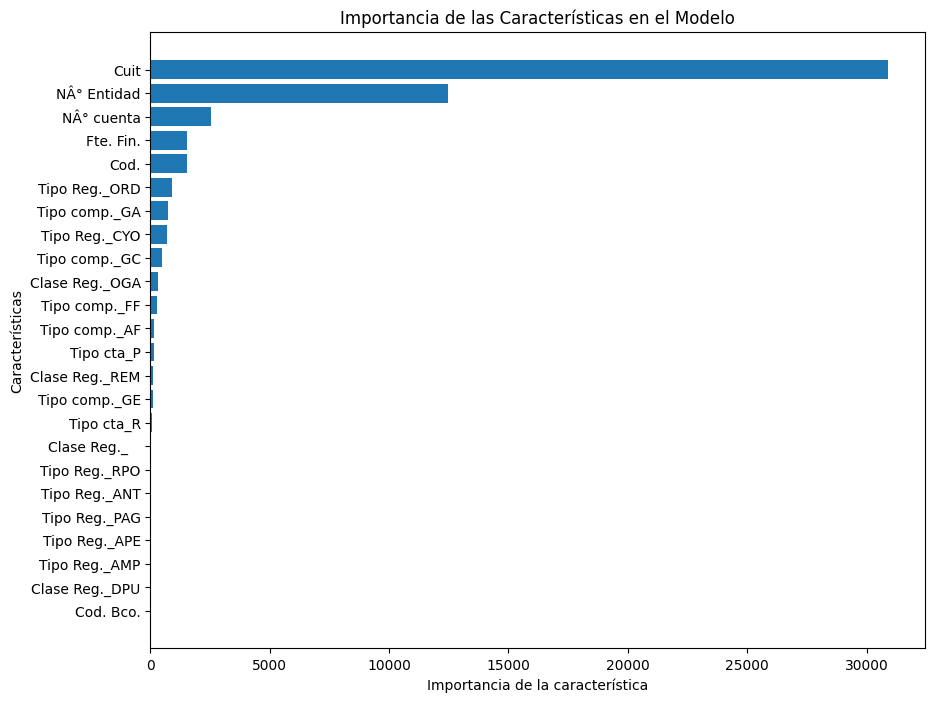

In [47]:
import matplotlib.pyplot as plt

# Asumiendo que ya has entrenado tu modelo con los mejores hiperparámetros encontrados
best_model = lgb.LGBMClassifier(**study.best_params)
best_model.fit(X_train, y_train)

# Obtener la importancia de las características
importance = best_model.feature_importances_

# Crear un DataFrame para visualizar mejor
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importance
}).sort_values(by='importance', ascending=False)

# Mostrar el DataFrame con la importancia de las variables
print(importance_df)

# Graficar la importancia de las variables
plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importancia de la característica')
plt.ylabel('Características')
plt.title('Importancia de las Características en el Modelo')
plt.gca().invert_yaxis()
plt.show()
